<a href="https://colab.research.google.com/github/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/blob/main/MMAI869_Pump_It_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MMAI 869, Smith School of Business at Queens University
###Team Broadview Project, Pump it Up: Data Mining the Water Table

###Import Libraries

In [1356]:
import numpy as np  
import pandas as pd  
import datetime as dt

# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score, plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report


from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.utils import compute_class_weight
from sklearn.metrics import plot_roc_curve


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


https://medium.com/analytics-vidhya/predictive-modeling-for-tanzanian-water-pumps-701bcc7760b2

https://towardsdatascience.com/predicting-the-functional-status-of-pumps-in-tanzania-355c9269d0c2

https://rstudio-pubs-static.s3.amazonaws.com/339668_006f4906390e41cea23b3b786cc0230a.html

https://itnext.io/predicting-functional-water-pumps-in-tanzania-using-random-forests-and-logistic-regression-in-ffa04b0617f2

https://towardsdatascience.com/pump-it-up-with-catboost-828bf9eaac68

### Check Allocated System Specs by Google Colab

In [1357]:
from psutil import *

cpu_count()

2

In [1358]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [1359]:
!df -h / |awk '{print $4}'

Avail
85G


In [1360]:
!free -h  --si | awk '/Mem:/{print $2}'

13G


In [1361]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1362]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



###Helper Function

In [1363]:
#method to print better looking plots

def pretty_importances_plot(importances, feature_name, fig_size = (10, 7), xlabel = '', ylabel = '', horizontal_label = None, n_elements=None):
    '''
    This function plots a better looking importances-plot
    
    importances: Occurences of feature_name
    feature_name: unique feature_name
    fig_size: size of plot
    xlabel: xlabel
    ylabel: ylabel
    horizontal_label: Bigger label at the top-left
    n_elements: number of elements to display
    '''
    
    # This code has been borrowed from:
    # https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
    # Credits to SIMONE CENTELLEGHER

    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'

    # percentages = pd.Series(data= list(map(operator.itemgetter(1), word_importances_title_entity)),
    #                       index = list(map(operator.itemgetter(0), word_importances_title_entity)))
    
    if not n_elements:
        n_elements = len(importances)
    
    percentages = pd.Series(
        data = importances[:n_elements],
        index = feature_name[:n_elements]
    )

    df = pd.DataFrame({'percentage' : percentages})
    df = df.sort_values(by='percentage')

    # we first need a numeric placeholder for the y axis
    my_range=list(range(1,len(df.index)+1))

    #fig, ax = plt.subplots(figsize=(5,3.5)) ######################
    fig, ax = plt.subplots(figsize=fig_size)


    # create for each expense type an horizontal line that starts at x = 0 with the length 
    # represented by the specific expense percentage value.
    plt.hlines(y=my_range, xmin=0, xmax=df['percentage'], color='#007ACC', alpha=0.2, linewidth=5)

    # create for each expense type a dot at the level of the expense percentage value
    plt.plot(df['percentage'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

    # set labels
    ax.set_xlabel(xlabel, fontsize=15, fontweight='black', color = '#333F4B')
    ax.set_ylabel(ylabel)
    
     # set axis
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.yticks(my_range, df.index)

    # add an horizonal label for the y axis
    if horizontal_label:
        fig.text(-0.23, 0.96, horizontal_label, fontsize=15, fontweight='black', color = '#333F4B')

    # change the style of the axis spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)

    # set the spines position
    ax.spines['bottom'].set_position(('axes', -0.04))
    ax.spines['left'].set_position(('axes', 0.015))

#1. Loading the dataset from GitHub: [MMAI869-Pump-it-Up-Competition]

  Data is accessed from github: (https://github.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition)



In [1364]:
ulr_Training_Set_Values = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Training_Set_Values.csv'
ulr_Training_Set_Labels = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Training_Set_Labels.csv'
ulr_Test_Set_Values = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Test_Set_Values.csv'
Training_Set_Values = pd.read_csv(ulr_Training_Set_Values)
Training_Set_Labels = pd.read_csv(ulr_Training_Set_Labels)
test = pd.read_csv(ulr_Test_Set_Values)
data = Training_Set_Values.merge(Training_Set_Labels, on='id', how='right')

In [1365]:
original_data = data

In [1366]:
original_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [1367]:
len(data)

59400

In [1368]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [1369]:
# data.isnull().sum()

In [1370]:
# test.isnull().sum()

#2- Data Cleaning and Imputation

In [1371]:
# data.info()

##2.1- Numerical Features
Some of the numerical features are actally categorical, since they get only certain values relating to a specific region, such as:
1.   region_code
2.   district_code

We will consider these in categorical features. Also the year constructed is a date&Time feature.

In [1372]:
df_numerical_features = data.select_dtypes(exclude='object')
df_numerical_features.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year'],
      dtype='object')

In [1373]:
data.region_code = data.region_code.astype(object)

In [1374]:
data.district_code = data.district_code.astype(object)

###2.1.1- amount_tsh
Total static head (amount water available to waterpoint)

https://inspectapedia.com/water/Well_Static_Head_Definition.php

The static head volume inside a water well tells us how much water is available to the pump after the well has rested, water has risen to its maximum height inside the well, and the pump is about to turn on.

* Depending on the unit of measurment for volume, some values might not make sense, we don't have the unit here
* We have 41639 values of zero, need to replace them with some representative number with assumption, i.e. mean of other values. I will consider only the values that are not occuring only once, just an auumption
* Need to remove outliers as well, lets decide which one is considered as outlier. Left them to be for now

In [1375]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html

data.amount_tsh.value_counts().sort_values(ascending=False)

0.00        41639
500.00       3102
50.00        2472
1000.00      1488
20.00        1463
            ...  
0.25            1
12.00           1
60000.00        1
306.00          1
59.00           1
Name: amount_tsh, Length: 98, dtype: int64

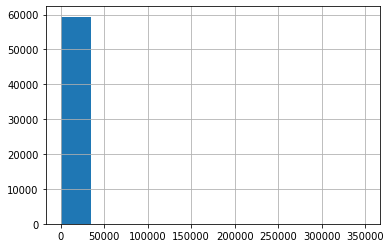

In [1376]:
data.amount_tsh.hist()

In [1377]:
# data[data['amount_tsh'].map(data['amount_tsh'].value_counts() > 1)]

In [1378]:
tsh_multiple_occurance_df = data.groupby('amount_tsh').filter(lambda x: len(x) > 1)
tsh_multiple_nonzero_occurance_df = tsh_multiple_occurance_df[tsh_multiple_occurance_df.amount_tsh>0]
tsh_multiple_nonzero_occurance_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,Pangani,Moa/Mwereme,Tanga,4,8,Mkinga,Moa,1,True,GeoData Consultants Ltd,VWC,Zingibali,True,2009,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional
11,50409,200.0,2013-02-18,Danida,1062,DANIDA,35.770258,-10.574175,Kwa Alid Nchimbi,0,Lake Nyasa,Ngondombwito,Ruvuma,10,5,Namtumbo,Msindo,250,True,GeoData Consultants Ltd,WUG,NaN,False,1987,swn 80,swn 80,handpump,wug,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
16,48451,500.0,2011-07-04,Unicef,1703,DWE,34.642439,-9.106185,Kwa John Mtenzi,0,Rufiji,Kidudumo,Iringa,11,4,Njombe,Mdandu,35,True,GeoData Consultants Ltd,WUA,wanging'ombe water supply s,True,1978,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,dry,dry,river,river/lake,surface,communal standpipe,communal standpipe,non functional


In [1379]:
tsh_zero_value_df = tsh_multiple_occurance_df[tsh_multiple_occurance_df.amount_tsh==0]
zero_tsh_index = tsh_zero_value_df.id.tolist()
data.loc[data['id'].isin(zero_tsh_index), 'amount_tsh'] = round(tsh_multiple_nonzero_occurance_df.amount_tsh.mean())

In [1380]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,984.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,984.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,984.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


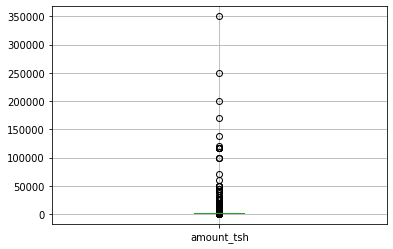

In [1381]:
boxplot = data.boxplot(column=['amount_tsh'])

* For the Na values, decided to use the most frequent value instead

###2.1.2- Coordinates: gps_height, longitude, latitude
Random forest's feature importance shows the geographical location is very important, top of the list.

* longitude and laltitude have 1812 zero values, whih are outside of Tanzania, so they are essentially Nan values. We will perform a KNN to predict them to improve the results.

In [1382]:
data.gps_height.value_counts()

 0       20438
-15         60
-16         55
-13         55
 1290       52
         ...  
 2378        1
-54          1
 2057        1
 2332        1
 2366        1
Name: gps_height, Length: 2428, dtype: int64

In [1383]:
data.longitude.value_counts()

0.000000     1812
37.375717       2
38.340501       2
39.086183       2
33.005032       2
             ... 
35.885754       1
36.626541       1
37.333530       1
38.970078       1
38.104048       1
Name: longitude, Length: 57516, dtype: int64

In [1384]:
data.latitude.value_counts()

-2.000000e-08    1812
-6.985842e+00       2
-6.980220e+00       2
-2.476680e+00       2
-6.978263e+00       2
                 ... 
-3.287619e+00       1
-8.234989e+00       1
-3.268579e+00       1
-1.146053e+01       1
-6.747464e+00       1
Name: latitude, Length: 57517, dtype: int64

In [1385]:
# pip install geopandas

In [1386]:
# pip install shapely

In [1387]:
# from shapely.geometry import Point
# import geopandas as gpd
# from geopandas import GeoDataFrame

# # df = pd.read_csv("Long_Lats.csv", delimiter=',', skiprows=0, low_memory=False)
# # (x=data.longitude, y=data.latitude
# geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
# gdf = GeoDataFrame(data, geometry=geometry)   

# #this is a simple map that goes with geopandas
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# gdf.plot(ax=world.plot(figsize=(20, 18)), marker='o', color='red', markersize=15);

In [1388]:
data.latitude.isnull().sum()

0

In [1389]:
longitude_zero_index = data[data.longitude == 0 ].id.tolist()
data.loc[data['id'].isin(longitude_zero_index), 'longitude']= np.NaN

In [1390]:
data['imputed_longitude']=0
data.loc[data['id'].isin(longitude_zero_index), 'imputed_longitude']=1


In [1391]:
latitude_zero_index = data[data.latitude == -2.000000e-08 ].id.tolist()
data.loc[data['id'].isin(latitude_zero_index), 'latitude']= np.NaN

In [1392]:
data['imputed_latitude']=0
data.loc[data['id'].isin(longitude_zero_index), 'imputed_latitude']=1

In [1393]:
gps_height_zero_index = data[data.gps_height == 0 ].id.tolist()
data.loc[data['id'].isin(gps_height_zero_index), 'gps_height']= np.NaN

In [1394]:
data['imputed_gps_height']=0
data.loc[data['id'].isin(longitude_zero_index), 'imputed_gps_height']=1

###2.1.3- num_private
num_private, This feature is mostly missing, so we will drop it from dataset. 98% of the num_private feature has value of zero, so we drop it from our dataset.

In [1395]:
data = data.drop(['num_private'], axis=1)
test = test.drop(['num_private'], axis=1)

###2.1.4- population
Population around the well

In [1396]:
data.population.value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
6330        1
5030        1
656         1
948         1
788         1
Name: population, Length: 1049, dtype: int64

In [1397]:
population_zero_index = data[data.population == 0 ].id.tolist()
data.loc[data['id'].isin(population_zero_index), 'population']= np.NaN

In [1398]:
data['imputed_population']=0
data.loc[data['id'].isin(longitude_zero_index), 'imputed_population']=1

In [1399]:
data.population.isnull().sum()

21381

##2.2- Categorical Features

Categorical features can have so many instances that happen only a few times or even once. This is not very informative for an ML model. 

This can lead to high cardinality.

We will create a new category for instances occuring "once"

Infrequent labels are so few, that it is hard to derive reliable information from them. But more importantly, infrequent labels tend to appear only on train set or only on the test set, leading to:

*   If only on the train set, they may cause over-fitting
*   If only on the test set, our machine learning model will not know how to score them

The identification of rare labels should be done using only the training set, and then propagated to the test set. Rare labels should be identified in the training set only. Thus, we will leave it for feature engineering stage.

https://github.com/solegalli/feature-engineering-for-machine-learning/blob/main/Section-06-Categorical-Encoding/06.10-Engineering-Rare-Categories.ipynb


In [1400]:
df_categorical_features = data.select_dtypes(include='object')
df_categorical_features.columns

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group'],
      dtype='object')

In [1401]:
# df_categorical_features.isnull().sum()

###2.2.1- Categorical features, No 'Rare" Value Encoding Required:  basin, region, source_class





In [1402]:
data.basin.value_counts().sort_values(ascending=False)

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

Text(0, 0.5, 'Number of Occurance')

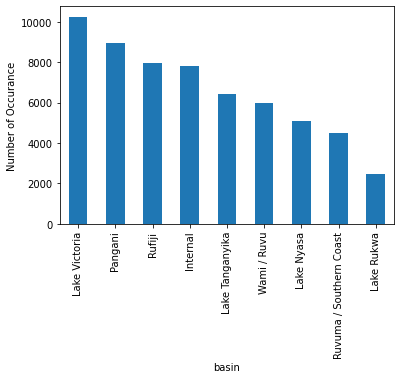

In [1403]:
data.basin.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('basin')
plt.ylabel('Number of Occurance')

In [1404]:
data.region.value_counts().sort_values(ascending=False)

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

Text(0, 0.5, 'Number of Occurance')

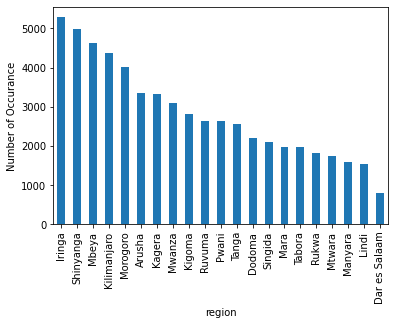

In [1405]:
data.region.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('region')
plt.ylabel('Number of Occurance')

In [1406]:
data.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

Text(0, 0.5, 'Number of Occurance')

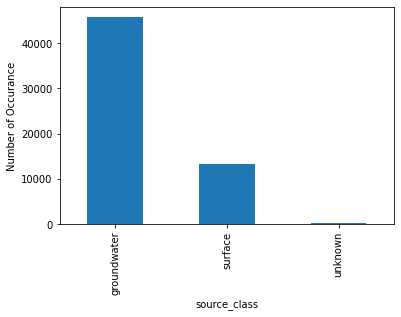

In [1407]:
data.source_class.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('source_class')
plt.ylabel('Number of Occurance')

###2.2.2- Categorical features, Features Might Need Cardinality Reduction. "Rare" Value Encoding Required

lga, ward, region_code, district_code, extraction_type, extraction_type_group, extraction_type_class, management, management_group, payment, payment_type, water_quality, quality_group, quantity, quantity_group, source, source_type, waterpoint_type, waterpoint_type_group


These features have no issue in terms of missing values, high cardinality might be an issue, will run rare value encoding with a threshold. We will encode them in feature engineering stage.

In [1408]:
data.lga.value_counts().sort_values(ascending=False)

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [1409]:
lga_once_occurance_df = data.groupby('lga').filter(lambda x: len(x) < 22)
# lga_once_occurance_df.head()
once_lga_index = lga_once_occurance_df.id.tolist()
print(len(once_lga_index))
# data.loc[data['id'].isin(once_lga_index), 'lga'] = "once"

22


Text(0, 0.5, 'Number of Occurance')

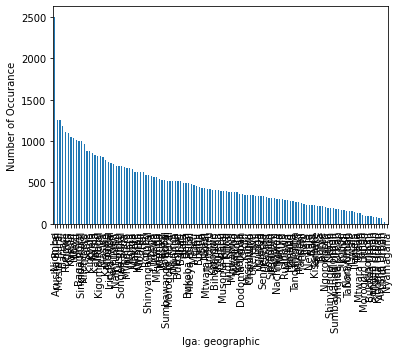

In [1410]:
data.lga.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('lga: geographic')
plt.ylabel('Number of Occurance')

In [1411]:
data.ward = data.ward.str.lower()

In [1412]:
data.ward.value_counts().sort_values(ascending=False)

igosi        307
imalinyi     252
siha kati    232
mdandu       231
nduruma      217
            ... 
kitete         1
ukata          1
sungwisi       1
mawenzi        1
kinungu        1
Name: ward, Length: 2092, dtype: int64

In [1413]:
ward_once_occurance_df = data.groupby('ward').filter(lambda x: len(x) < 2 )
# ward_once_occurance_df.head()
once_ward_index = ward_once_occurance_df.id.tolist()
print(len(once_ward_index))
# data.loc[data['id'].isin(once_ward_index), 'ward'] = "once"

30


In [1414]:
data.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

Text(0, 0.5, 'Number of Occurance')

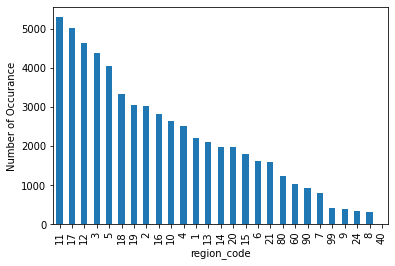

In [1415]:
data.region_code.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('region_code')
plt.ylabel('Number of Occurance')

In [1416]:
data.district_code.value_counts().sort_values(ascending=False)

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

Text(0, 0.5, 'Number of Occurance')

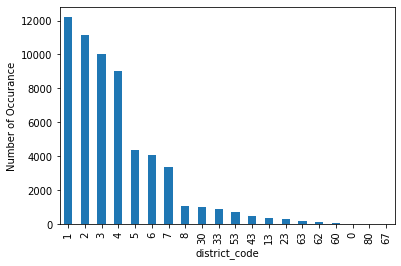

In [1417]:
data.district_code.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('district_code')
plt.ylabel('Number of Occurance')

In [1418]:
data.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

Text(0, 0.5, 'Number of Occurance')

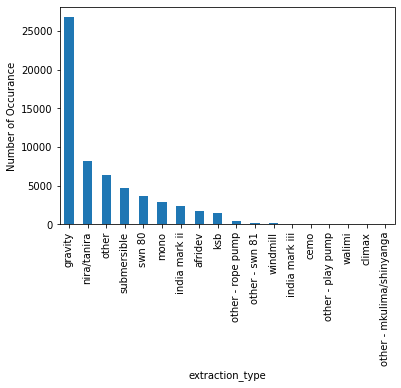

In [1419]:
data.extraction_type.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('extraction_type')
plt.ylabel('Number of Occurance')

In [1420]:
data.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

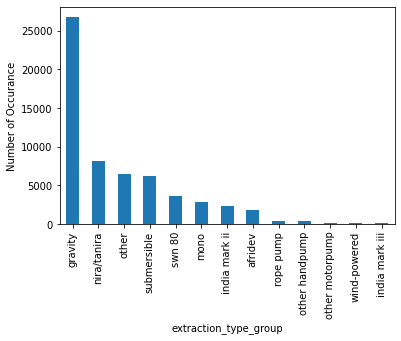

In [1421]:
data.extraction_type_group.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('extraction_type_group')
plt.ylabel('Number of Occurance')

In [1422]:
data.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

Text(0, 0.5, 'Number of Occurance')

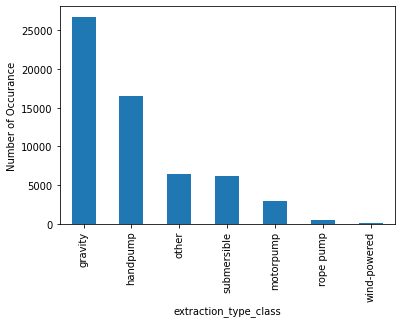

In [1423]:
data.extraction_type_class.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('extraction_type_class')
plt.ylabel('Number of Occurance')

In [1424]:
data.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

Text(0, 0.5, 'Number of Occurance')

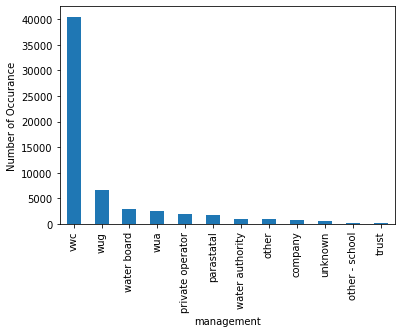

In [1425]:
data.management.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('management')
plt.ylabel('Number of Occurance')

In [1426]:
data.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

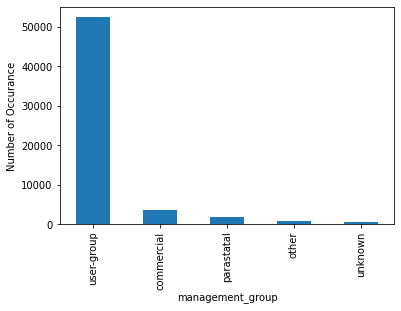

In [1427]:
data.management_group.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('management_group')
plt.ylabel('Number of Occurance')

In [1428]:
data.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

Text(0, 0.5, 'Number of Occurance')

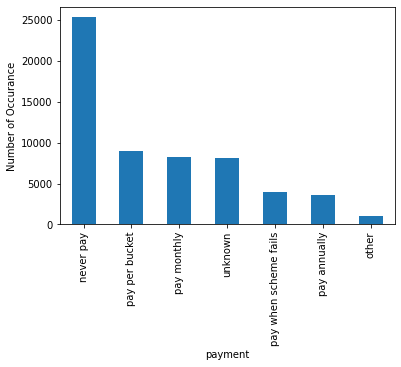

In [1429]:
data.payment.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('payment')
plt.ylabel('Number of Occurance')

In [1430]:
data.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

Text(0, 0.5, 'Number of Occurance')

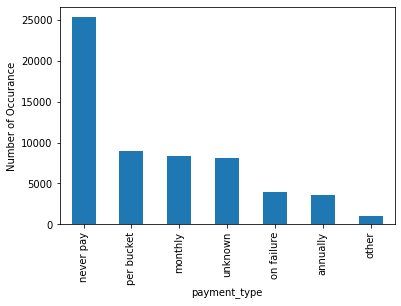

In [1431]:
data.payment_type.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('payment_type')
plt.ylabel('Number of Occurance')

In [1432]:
data.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

Text(0, 0.5, 'Number of Occurance')

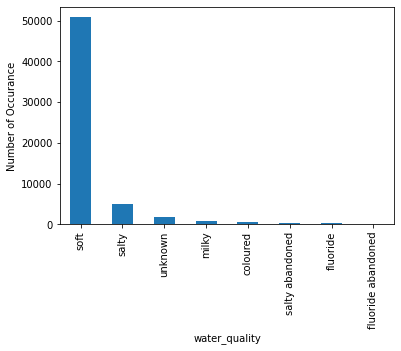

In [1433]:
data.water_quality.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('water_quality')
plt.ylabel('Number of Occurance')

In [1434]:
data.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

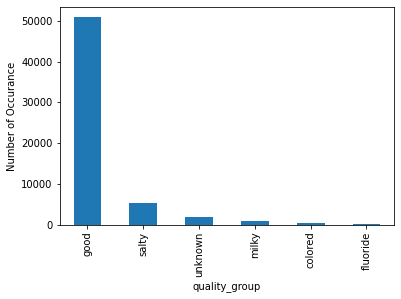

In [1435]:
data.quality_group.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('quality_group')
plt.ylabel('Number of Occurance')

In [1436]:
data.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

Text(0, 0.5, 'Number of Occurance')

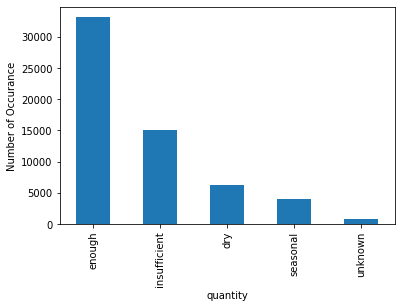

In [1437]:
data.quantity.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('quantity')
plt.ylabel('Number of Occurance')

In [1438]:
data.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

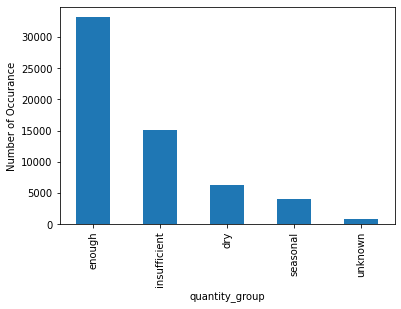

In [1439]:
data.quantity_group.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('quantity_group')
plt.ylabel('Number of Occurance')

In [1440]:
data.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

Text(0, 0.5, 'Number of Occurance')

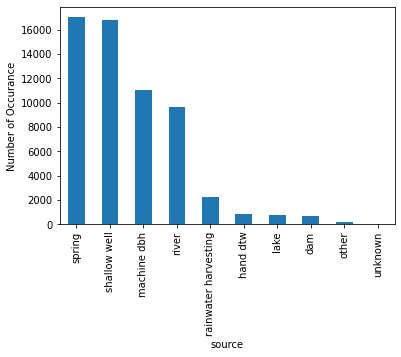

In [1441]:
data.source.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('source')
plt.ylabel('Number of Occurance')

In [1442]:
data.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

Text(0, 0.5, 'Number of Occurance')

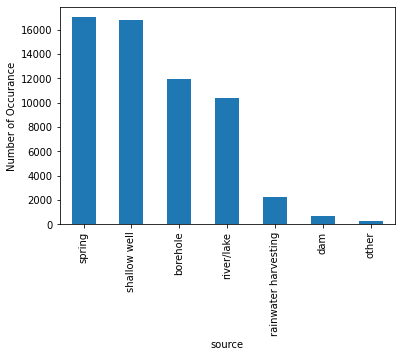

In [1443]:
data.source_type.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('source')
plt.ylabel('Number of Occurance')

In [1444]:
data.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

Text(0, 0.5, 'Number of Occurance')

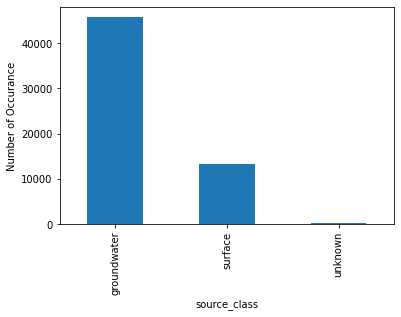

In [1445]:
data.source_class.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('source_class')
plt.ylabel('Number of Occurance')

In [1446]:
data.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

Text(0, 0.5, 'Number of Occurance')

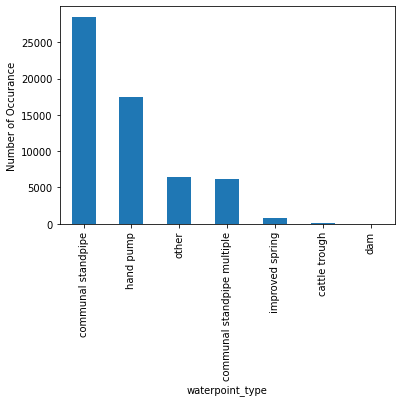

In [1447]:
data.waterpoint_type.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('waterpoint_type')
plt.ylabel('Number of Occurance')

In [1448]:
data.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

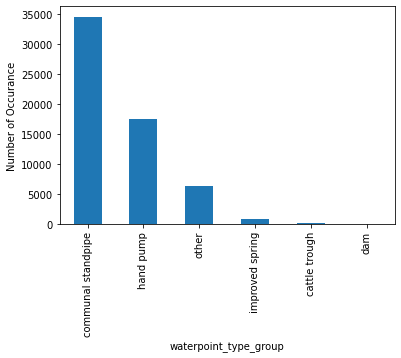

In [1449]:
data.waterpoint_type_group.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('waterpoint_type_group')
plt.ylabel('Number of Occurance')

###2.2.3- Highly Cardinal Features, with Missing value: funder, installer, wpt_name, subvillage, scheme_management, scheme_name

These features are also highly cardinal but have missing values as well. We will create a "Missing" category for them since there are so many NaN. We will use rare lable encoding to deal with high cardinality, which has to be done in feature engineering stage, after the train and test split.

In [1450]:
#Check for missing values in funder
df_categorical_features.funder.isnull().sum()

3635

In [1451]:
data.funder.fillna('Missing', inplace=True)
test.funder.fillna('Missing', inplace=True)

In [1452]:
data.funder.value_counts().sort_values(ascending=False)

Government Of Tanzania     9084
Missing                    3635
Danida                     3114
Hesawa                     2202
Rwssp                      1374
                           ... 
Owner Pingo C                 1
Mzee Salum Bakari Darus       1
Masista                       1
Dasp Ltd                      1
Samlo                         1
Name: funder, Length: 1898, dtype: int64

In [1453]:
funder_once_occurance_df = data.groupby('funder').filter(lambda x: len(x) < 2 )
# funder_once_occurance_df.head()
once_funder_index = funder_once_occurance_df.id.tolist()
print(len(once_funder_index))
# data.loc[data['id'].isin(once_funder_index), 'funder'] = "once"

974


In [1454]:
#Check for missing values in installer
df_categorical_features.installer.isnull().sum()

3655

In [1455]:
data.installer = data.installer.str.lower()

In [1456]:
data.installer.fillna('Missing', inplace=True)
test.installer.fillna('Missing', inplace=True)

In [1457]:
data.installer.value_counts().sort_values(ascending=False)

dwe                        17405
Missing                     3655
government                  1891
hesawa                      1395
rwe                         1206
                           ...  
upm                            1
magul                          1
village water attendant        1
hanja                          1
selepta                        1
Name: installer, Length: 1936, dtype: int64

In [1458]:
installer_once_occurance_df = data.groupby('installer').filter(lambda x: len(x) < 2 )
# installer_once_occurance_df.head()
once_installer_index = installer_once_occurance_df.id.tolist()
print(len(once_installer_index))
# data.loc[data['id'].isin(once_installer_index), 'installer'] = "once"

974


wpt_name has many 'none' values, we will change them to NaN and replace them with a category called missing, this can be done now before spliting.

In [1459]:
wpt_name_none_index = data[data.wpt_name=='none'].id.tolist()
data.loc[data['id'].isin(wpt_name_none_index), 'wpt_name']= np.NaN

In [1460]:
data.wpt_name.fillna('Missing', inplace=True)
test.wpt_name.fillna('Missing', inplace=True)

In [1461]:
data.wpt_name.value_counts().sort_values(ascending=False)

Missing            3563
Shuleni            1748
Zahanati            830
Msikitini           535
Kanisani            323
                   ... 
Mukashalakima         1
Nholo                 1
Majembwa              1
Kwa Mzee Jonas        1
Kwa Mzee Lugawa       1
Name: wpt_name, Length: 37400, dtype: int64

In [1462]:
wpt_name_once_occurance_df = data.groupby('wpt_name').filter(lambda x: len(x) < 2 )
# wpt_name_once_occurance_df.head()
once_wpt_name_index = wpt_name_once_occurance_df.id.tolist()
print(len(once_wpt_name_index))
# data.loc[data['id'].isin(once_wpt_name_index), 'wpt_name'] = "once"

32928


In [1463]:
data.subvillage.isnull().sum()

371

In [1464]:
data.subvillage.fillna('Missing', inplace=True)
test.subvillage.fillna('Missing', inplace=True)

In [1465]:
data.subvillage.value_counts().sort_values(ascending=False)

Madukani        508
Shuleni         506
Majengo         502
Kati            373
Missing         371
               ... 
Nakansindwi       1
Omurutenge        1
Ihagaha           1
Ngomba Chini      1
Kikatanyemba      1
Name: subvillage, Length: 19288, dtype: int64

In [1466]:
subvillage_once_occurance_df = data.groupby('subvillage').filter(lambda x: len(x) < 2 )
# subvillage_once_occurance_df.head()
once_subvillage_index = subvillage_once_occurance_df.id.tolist()
print(len(once_subvillage_index))
# data.loc[data['id'].isin(once_subvillage_index), 'subvillage'] = "once"

9424


In [1467]:
data.scheme_management.isnull().sum()

3877

In [1468]:
data.scheme_management.fillna('Missing', inplace=True)
test.scheme_management.fillna('Missing', inplace=True)

In [1469]:
data.scheme_management.value_counts().sort_values(ascending=False)

VWC                 36793
WUG                  5206
Missing              3877
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

scheme_management has one 'none' value, we will replace it with the "other" cateory.

In [1470]:
scheme_management_none_index = data[data.scheme_management=='None'].id.tolist()
data.loc[data['id'].isin(scheme_management_none_index), 'scheme_management']= 'Other'

Text(0, 0.5, 'Number of Occurance')

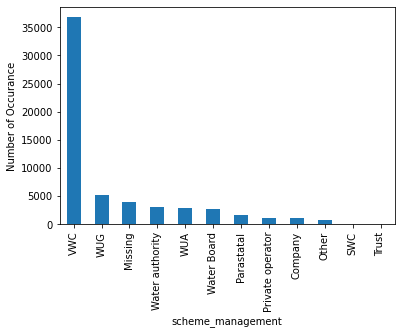

In [1471]:
data.scheme_management.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('scheme_management')
plt.ylabel('Number of Occurance')

scheme_name has 'None' categort, which we will leave it as category "None"

In [1472]:
data.scheme_name.isnull().sum()

28166

In [1473]:
data.scheme_name.fillna('Missing', inplace=True)
test.scheme_name.fillna('Missing', inplace=True)

In [1474]:
data.scheme_name = data.scheme_name.str.lower()

In [1475]:
data.scheme_name.value_counts()

missing                     28166
k                             685
none                          669
borehole                      546
chalinze wate                 406
                            ...  
merali juu line                 1
izunya                          1
ukuu                            1
nya/mak/buk piped scheme        1
mtawanya                        1
Name: scheme_name, Length: 2577, dtype: int64

In [1476]:
scheme_name_once_occurance_df = data.groupby('scheme_name').filter(lambda x: len(x) < 2 )
# scheme_name_once_occurance_df.head()
once_scheme_name_index = scheme_name_once_occurance_df.id.tolist()
print(len(once_scheme_name_index))
# data.loc[data['id'].isin(once_scheme_name_index), 'scheme_name'] = "once"

629


###2.2.4- Boolian Features, with Missing Values: public_meeting, permit

In [1477]:
data.public_meeting.isnull().sum()

3334

In [1478]:
data.public_meeting.fillna('Missing', inplace=True)
test.public_meeting.fillna('Missing', inplace=True)

In [1479]:
data.public_meeting = data.public_meeting.replace({True: 'Yes', False: 'No'})

Text(0, 0.5, 'Number of Occurance')

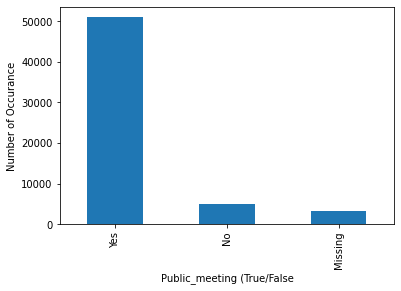

In [1480]:
data.public_meeting.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Public_meeting (True/False')
plt.ylabel('Number of Occurance')

In [1481]:
data.permit.isnull().sum()

3056

In [1482]:
data.permit.fillna('Missing', inplace=True)
test.permit.fillna('Missing', inplace=True)

In [1483]:
data.permit = data.permit.replace({True: 'Yes', False: 'No'})

Text(0, 0.5, 'Number of Occurance')

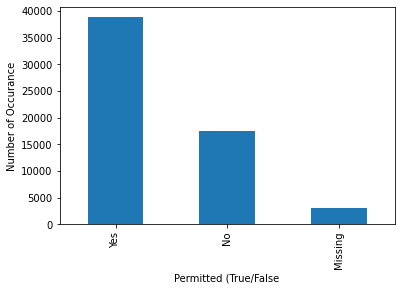

In [1484]:
data.permit.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Permitted (True/False')
plt.ylabel('Number of Occurance')

###2.2.5- No value features
Some categorical features have only one unique instance

In [1485]:
data.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [1486]:
data = data.drop(['recorded_by'], axis=1)

In [1487]:
test = test.drop(['recorded_by'], axis=1)

##2.3- Date and Time Features

###2.3.1. date_recorded
The date the row was entered
* Date recorded does not add much value by itself, we might only need the year. So, only the year row was entere is keeped. The other info of the feature can be used to find the day of the week, month, season, etc. of row recorded. The season might add some vale since it can be rainy or dry season in Tanzania. We will extract the season by percipitation amounts and add it as a new feature to the dataset. 
*Percipitation amount around the date the row was recorded can be valuable info, percipitation_amount above 100mm is assumed "high" and lower than 100mm assumed "low", indicating rainy and dry seasons. 

In [1488]:
data.date_recorded.isnull().sum()

0

In [1489]:
# data.info()

In [1490]:
data.date_recorded = pd.to_datetime(data.date_recorded)

In [1491]:
data['year_recorded'] = data.date_recorded.dt.year

In [1492]:
data['month_recorded'] = data.date_recorded.dt.month

In [1493]:
data['day_recorded'] = data.date_recorded.dt.weekday

In [1494]:
data['quarer_recorded'] = data.date_recorded.dt.quarter

In [1495]:
data = data.drop(['date_recorded'],axis=1)

In [1496]:
data['percipitation_class'] = data['month_recorded']
data['percipitation_class']=0

In [1497]:
import numpy as np
data['percipitation_class'] = np.where((data['month_recorded'] == 1), 4, data['percipitation_class'])
data['percipitation_class'] = np.where((data['month_recorded'] == 3), 4, data['percipitation_class'])
data['percipitation_class'] = np.where((data['month_recorded'] == 12), 3, data['percipitation_class'])
data['percipitation_class'] = np.where((data['month_recorded'] == 2), 2, data['percipitation_class'])
data['percipitation_class'] = np.where((data['month_recorded'] == 4), 2, data['percipitation_class'])
data['percipitation_class'] = np.where((data['month_recorded'] == 11), 1, data['percipitation_class'])

In [1498]:
data.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,imputed_longitude,imputed_latitude,imputed_gps_height,imputed_population,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class
0,69572,6000.0,Roman,1390.0,roman,34.938093,-9.856322,Missing,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,mundindi,109.0,Yes,VWC,roman,No,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,0,0,0,0,2011,3,0,1,4
1,8776,984.0,Grumeti,1399.0,grumeti,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,2,Serengeti,natta,280.0,Missing,Other,missing,Yes,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0,0,0,0,2013,3,2,1,4
2,34310,25.0,Lottery Club,686.0,world vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,4,Simanjiro,ngorika,250.0,Yes,VWC,nyumba ya mungu pipe scheme,Yes,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,0,0,0,0,2013,2,0,1,2
3,67743,984.0,Unicef,263.0,unicef,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,nanyumbu,58.0,Yes,VWC,missing,Yes,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,0,0,0,0,2013,1,0,1,4
4,19728,984.0,Action In A,NaN,artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,nyakasimbi,NaN,Yes,Missing,missing,Yes,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0,0,0,0,2011,7,2,3,0


In [1499]:
# data.year_recorded = data.date_recorded.str.replace('-','')
# data.year_recorded = data.year_recorded.str[:4]
# data.year_recorded = data.year_recorded.astype(int)

In [1500]:
# test.date_recorded = test.date_recorded.str.replace('-','')
# test.date_recorded = test.date_recorded.str[:4]
# test.date_recorded = test.date_recorded.astype(int)

###2.1.10- construction_year
The year the waterpoint was constructed. This feature has so many 0 values, 20709, that does not make sense. The next most frequent year is 2645, the ratio to the next frequent i about 10 times. Replacing the year zero that we assume that are missing data, with any specific year in the dataset, mean /mode will skew the distribution drastically and will over represent one class. Thus, doing so is not adding any value to the model.

As an easy and initial solution, We will distribute them over all years to keep the distribution, based on ratio of those year in the total number of years. We will also add an indicating feature to flag the imputed year to the model.

After, we will do multivariate encoding to guess the year based on other features.

* This step has to happen after test and train split so our model does not overfit and give us misleading results.
* we can calculate the age of the well at the date of recording the row.


In [1501]:
# data.construction_year.value_counts()

In [1502]:
print(round(20709/59400*100,1), 'of data for construction_year is missing')

34.9 of data for construction_year is missing


In [1503]:
construction_year_zero_index = data[data.construction_year == 0 ].id.tolist()
data.loc[data['id'].isin(construction_year_zero_index), 'construction_year']= np.NaN

In [1504]:
# test.construction_year.value_counts()

Text(0, 0.5, 'Number of Occurance')

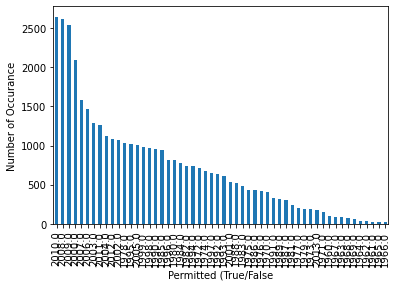

In [1505]:
data.construction_year.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Permitted (True/False')
plt.ylabel('Number of Occurance')

In [1506]:
data.construction_year.isnull().sum()

20709

In [1507]:
construction_year_zero_index = test[test.construction_year == 0 ].id.tolist()
test.loc[test['id'].isin(construction_year_zero_index), 'construction_year']= np.NaN

Text(0, 0.5, 'Number of Occurance')

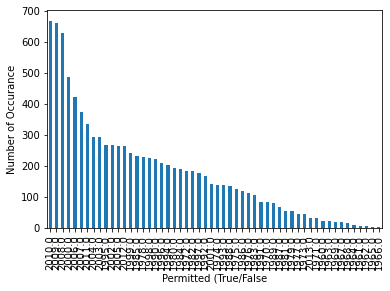

In [1508]:
test.construction_year.value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Permitted (True/False')
plt.ylabel('Number of Occurance')

In [1509]:
# construction_year_zero_index = data[data.construction_year==0].id.tolist()
# data.loc[data['id'].isin(construction_year_zero_index), 'construction_year']= np.NaN
# data['construction_year'].fillna(1950, inplace=True)

# # fillna('Missing', inplace=True)


In [1510]:
# construction_year_zero_index = data[data.construction_year==0].id.tolist()
# data.loc[data['id'].isin(construction_year_zero_index), 'construction_year']= np.NaN
# data['construction_year'].fillna(data['construction_year'].mode()[0], inplace=True)

 FE References


https://maxhalford.github.io/blog/target-encoding/

https://towardsdatascience.com/target-encoding-for-multi-class-classification-c9a7bcb1a53

https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64#:~:text=From%20the%20documentation%20linked%20above,over%20all%20the%20training%20data.%E2%80%9D

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/target-encoding.html

https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

https://www.kaggle.com/code/ryanholbrook/target-encoding

https://www.rasgoml.com/feature-engineering-tutorials/how-to-do-target-encoding

https://feature-engine.readthedocs.io/en/latest/

https://www.dropbox.com/sh/2vtm7k5maiyqrob/AAD7fm7Xwk6Ye9G54pgFRdFea?dl=0

https://queensu.udemy.com/course/feature-engineering-for-machine-learning/learn/lecture/9446014#overview

Target Encoding
Target encoding is a Baysian encoding technique.

Bayesian encoders use information from dependent/target variables to encode the categorical data.

In target encoding, we calculate the mean of the target variable for each category and replace the category variable with the mean value. In the case of the categorical target variables, the posterior probability of the target replaces each category.

In [1511]:
# import category_encoders as ce
# import pandas as pd
# data=pd.DataFrame({'City':[
# 'Delhi','Mumbai','Hydrabad','Chennai','Bangalore','Delhi','Hydrabad','Bangalore','Delhi'
# ]})

# #Create object for one-hot encoding
# encoder=ce.OneHotEncoder(cols='City',handle_unknown='return_nan',return_df=True,use_cat_names=True)

# #Original Data
# data

In [1512]:
# for i in data.columns:
#   data[i].fillna(data[i].mode()[0], inplace=True)
# for i in test.columns:
#   test[i].fillna(test[i].mode()[0], inplace=True)
# data.isnull().sum().sum(), test.isnull().sum().sum()

In [1513]:
# #Fit and transform Data
# data_encoded = encoder.fit_transform(data)
# data_encoded

In [1514]:
# #import the libraries
# import pandas as pd
# import category_encoders as ce

# #Create the Dataframe
# data=pd.DataFrame({'class':['A,','B','C','B','C','A','A','A'],'Marks':[50,30,70,80,45,97,80,68]})

# #Create target encoding object
# encoder=ce.TargetEncoder(cols='class') 

# #Original Data
# Data

#3- Feature Engineering
Rare values are categories within a categorical variable that are present only in a small percentage of the observations. There is no rule of thumb to determine how small is a small percentage, but typically, any value below 5 % can be considered rare.

* Grouping categories into rare for variables that show low cardinality may or may not improve model performance, however, we tend to re-group them into a new category to smooth model deployment.

* Grouping categories into rare for variables with high cardinality, tends to improve model performance as well.

https://github.com/solegalli/feature-engineering-for-machine-learning/blob/main/Section-06-Categorical-Encoding/06.10-Engineering-Rare-Categories.ipynb

The identification of rare labels should be done using only the training set, and then propagated to the test set. Rare labels should be identified in the training set only. In practice, what we will do is identify non-rare labels, and then any other label, either in the train or the test or future live data that is not in that list of non-rare labels, will be re=grouped into the new category.

In [1515]:
# pip install feature_engine

In [1516]:
from feature_engine.encoding import RareLabelEncoder
pd.set_option('display.max_columns', None)

##3.1- Rare Value Encoding for Categorical Features
features like 'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name' have so many values as 1, 2, 3 etc. We will train another encoder for them

https://feature-engine.readthedocs.io/en/0.6.x_a/encoders/RareLabelCategoricalEncoder.html

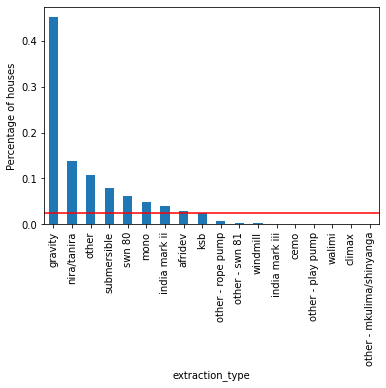

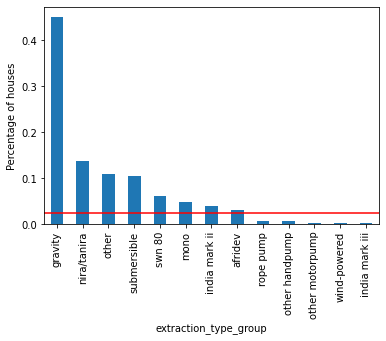

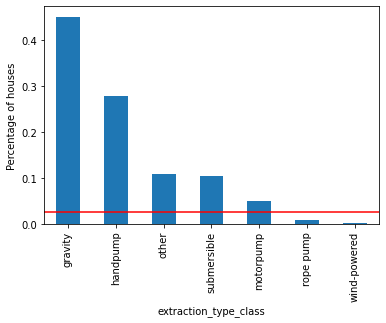

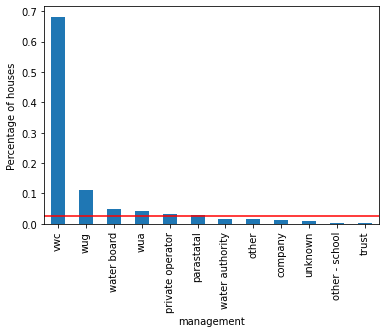

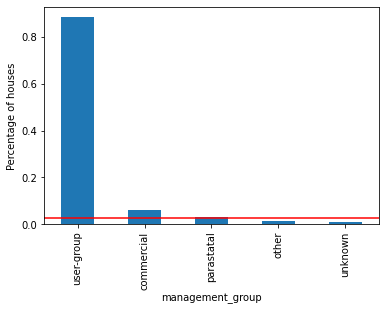

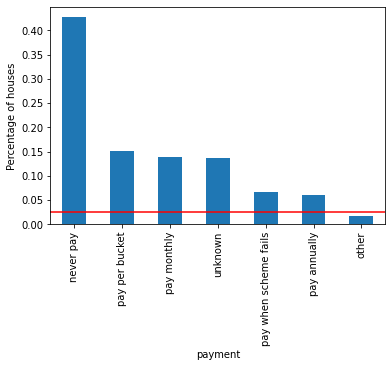

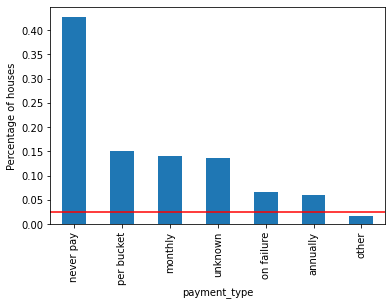

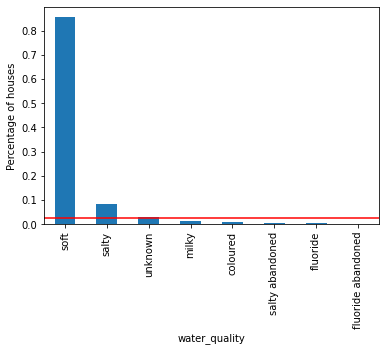

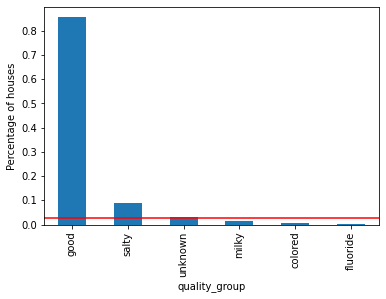

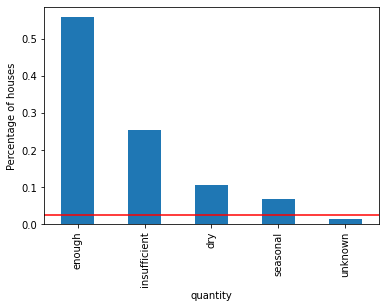

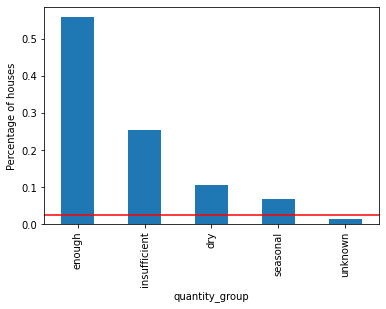

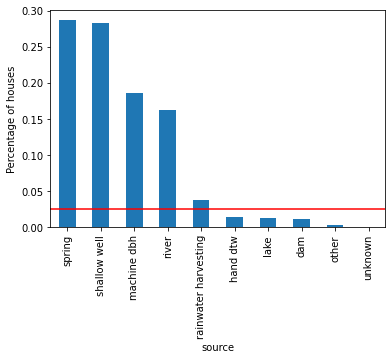

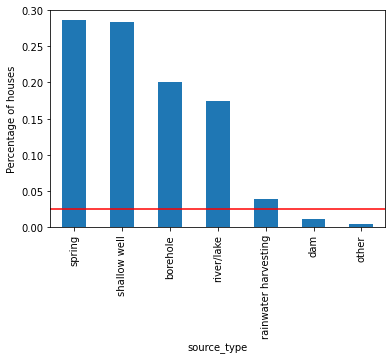

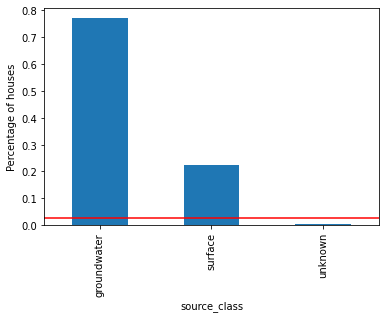

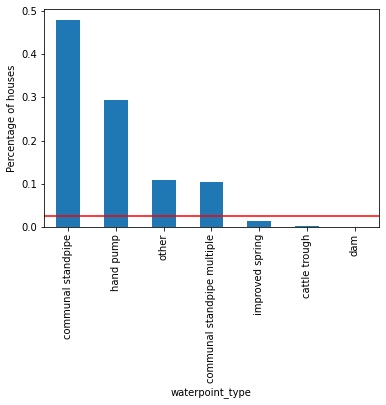

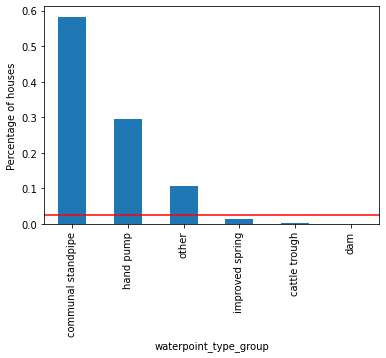

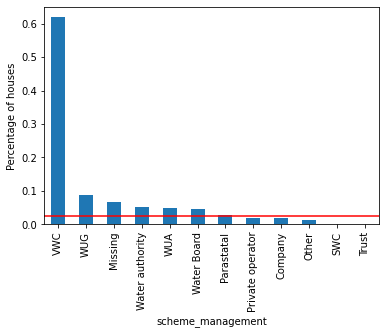

In [1517]:
for col in ['extraction_type', 
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type', 
               'waterpoint_type_group',
               'scheme_management'
            ]:

    temp_df = pd.Series(data[col].value_counts() / len(data) )

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.025, color='red')
    fig.set_ylabel('Percentage of houses')
    plt.show()

In [1518]:
rare_encoder = RareLabelEncoder(
    tol=0.025,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=['extraction_type',
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type',
               'waterpoint_type_group',
               'scheme_management'], # variables to re-group
    replace_with='Rare'
)  

##3.2- Rare Value Encoding for Extremely Cardinal Categorical Features

In [1519]:
# data.funder.isnull().sum()

In [1520]:
rare_encoder_EXtreme_Cardinality = RareLabelEncoder(
    tol=0.007,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    max_n_categories = 75,
    variables=['lga', 'funder', 'installer', 'wpt_name', 'subvillage', 'scheme_name'], # variables to re-group
    replace_with='Rare'
)  

In [1521]:
# data.ward.value_counts()

In [1522]:
rare_encoder_ExCard_ward = RareLabelEncoder(
    tol=0.002,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    max_n_categories = 75,
    variables=['ward'], # variables to re-group
    replace_with='Rare'
)

In [1523]:
rare_encoder.fit(data)

/usr/local/lib/python3.8/dist-packages/feature_engine/encoding/rare_label.py:199: UserWarning: The number of unique categories for variable source_class is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


RareLabelEncoder(n_categories=4, tol=0.025,
                 variables=['extraction_type', 'extraction_type_group',
                            'extraction_type_class', 'management',
                            'management_group', 'payment', 'payment_type',
                            'water_quality', 'quality_group', 'quantity',
                            'quantity_group', 'source', 'source_type',
                            'source_class', 'waterpoint_type',
                            'waterpoint_type_group', 'scheme_management'])

In [1524]:
rare_encoder_EXtreme_Cardinality.fit(data)

RareLabelEncoder(max_n_categories=75, n_categories=4, tol=0.007,
                 variables=['lga', 'funder', 'installer', 'wpt_name',
                            'subvillage', 'scheme_name'])

In [1525]:
rare_encoder_ExCard_ward.fit(data)

RareLabelEncoder(max_n_categories=75, n_categories=4, tol=0.002,
                 variables=['ward'])

In [1526]:
# rare_encoder.variables_

In [1527]:
# rare_encoder.encoder_dict_

###3.2.1- Transform Data with Encoder

In [1528]:
data = rare_encoder.transform(data)
# X_test = rare_encoder.transform(X_test.fillna('Missing'))

In [1529]:
data = rare_encoder_EXtreme_Cardinality.transform(data)
# X_test = rare_encoder.transform(X_test.fillna('Missing'))

In [1530]:
data = rare_encoder_ExCard_ward.transform(data)

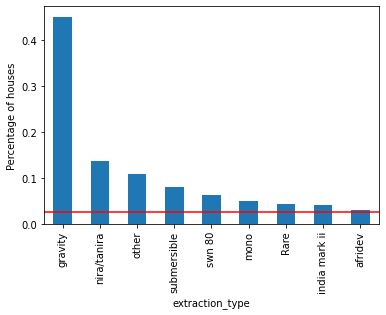

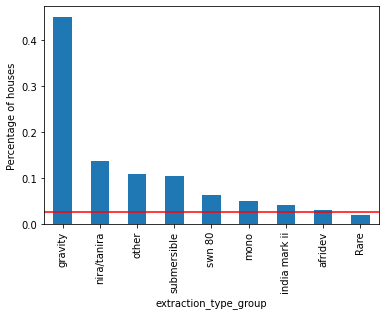

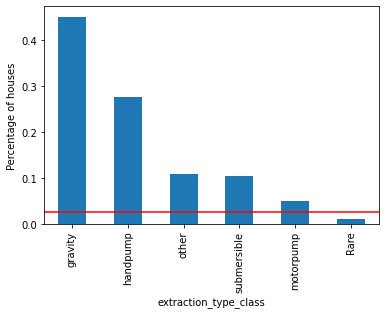

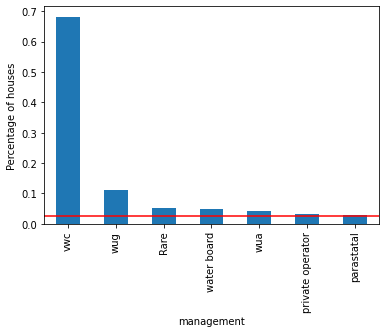

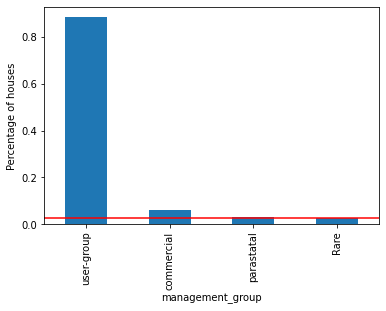

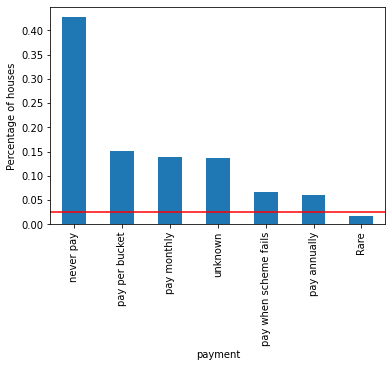

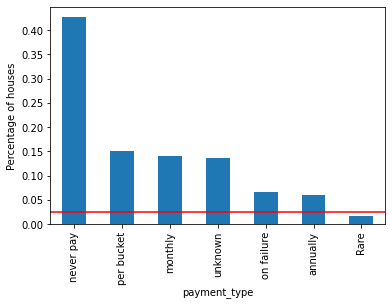

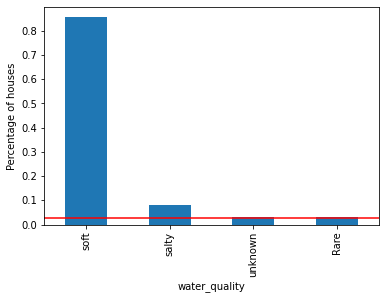

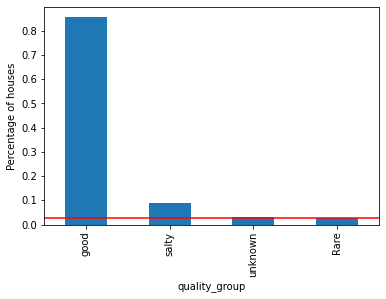

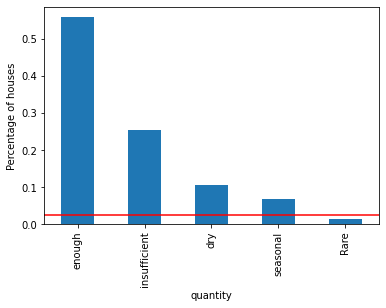

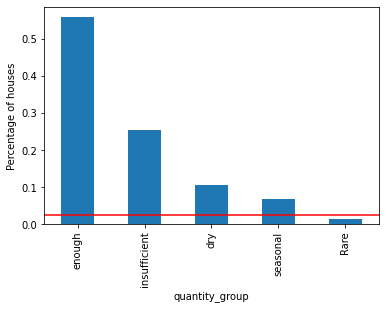

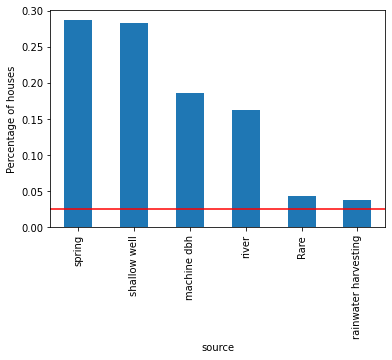

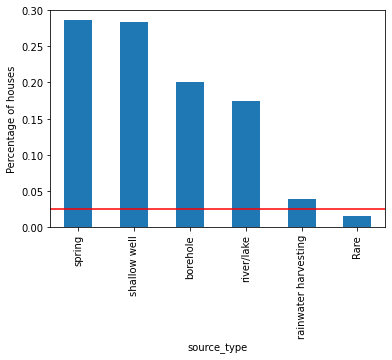

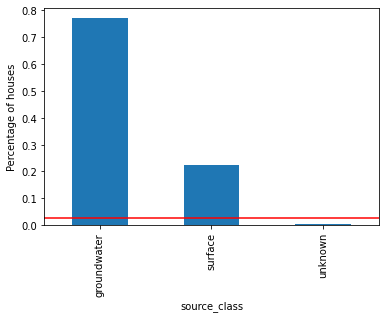

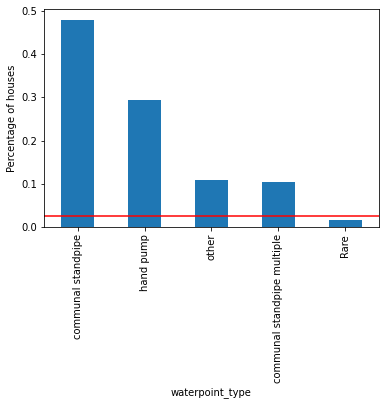

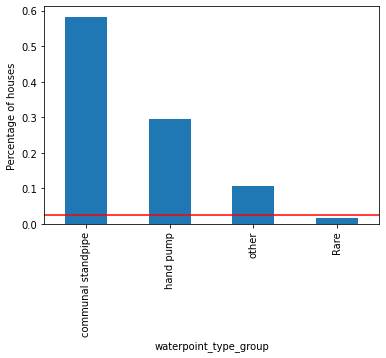

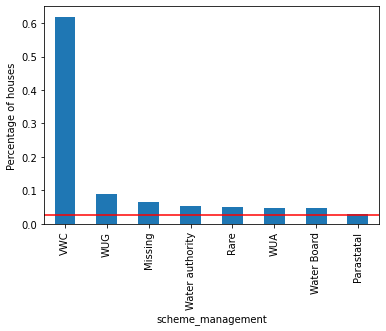

In [1531]:
for col in ['extraction_type', 
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type',
               'waterpoint_type_group',
               'scheme_management']:

    temp_df = pd.Series(data[col].value_counts() / len(data) )

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.025, color='red')
    fig.set_ylabel('Percentage of houses')
    plt.show()

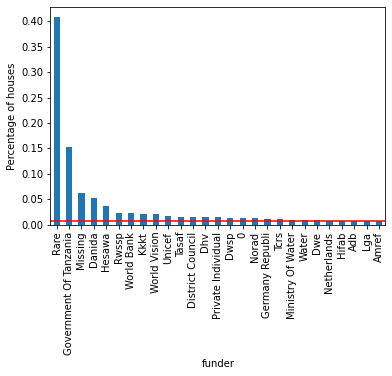

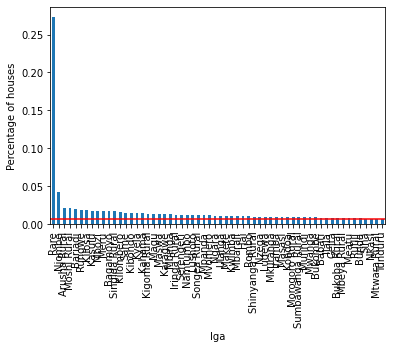

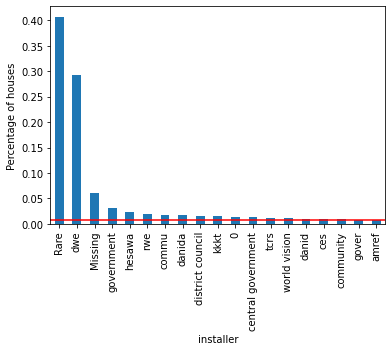

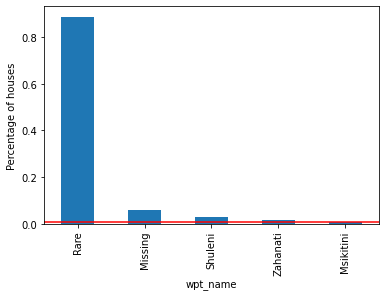

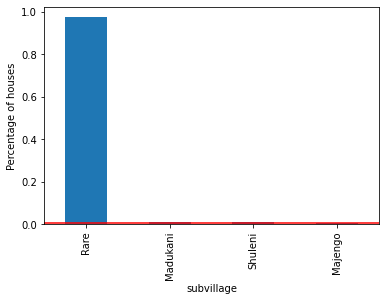

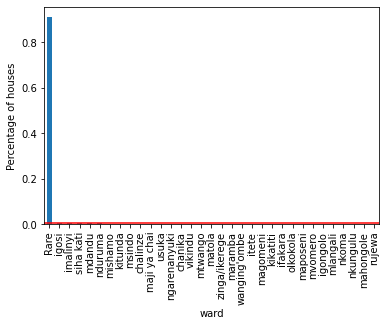

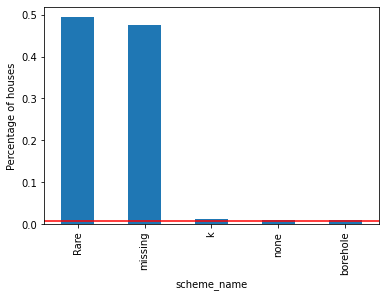

In [1532]:
for col in ['funder', 'lga', 'installer', 'wpt_name', 'subvillage', 'ward', 'scheme_name']:

    temp_df = pd.Series(data[col].value_counts() / len(data) )

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.007, color='red')
    fig.set_ylabel('Percentage of houses')
    plt.show()

In [1533]:
# check for cardinality in categorical variables

for var in ['extraction_type', 'funder', 'installer', 'wpt_name', 'subvillage', 'ward', 'scheme_name', 'lga', 'basin', 'region', 'public_meeting', 'permit',
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type', 
               'waterpoint_type_group',
               'scheme_management']:
    
    print(var, ' contains ', len(data[var].unique()), ' labels')


extraction_type  contains  9  labels
funder  contains  27  labels
installer  contains  19  labels
wpt_name  contains  5  labels
subvillage  contains  4  labels
ward  contains  33  labels
scheme_name  contains  5  labels
lga  contains  60  labels
basin  contains  9  labels
region  contains  21  labels
public_meeting  contains  3  labels
permit  contains  3  labels
extraction_type_group  contains  9  labels
extraction_type_class  contains  6  labels
management  contains  7  labels
management_group  contains  4  labels
payment  contains  7  labels
payment_type  contains  7  labels
water_quality  contains  4  labels
quality_group  contains  4  labels
quantity  contains  5  labels
quantity_group  contains  5  labels
source  contains  6  labels
source_type  contains  6  labels
source_class  contains  3  labels
waterpoint_type  contains  5  labels
waterpoint_type_group  contains  4  labels
scheme_management  contains  8  labels


#2.2.1- Label Distribution
Multiclass Classification Labels, need to encode them

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

Text(0, 0.5, 'Number of Occurance')

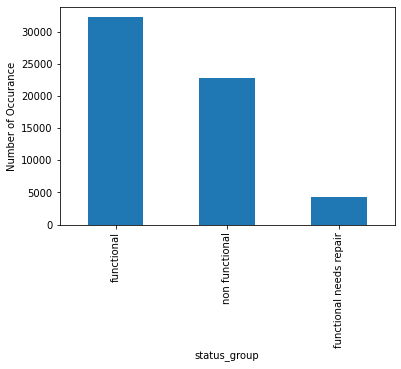

In [1534]:
data.status_group.value_counts().plot.bar()
plt.xlabel('status_group')
plt.ylabel('Number of Occurance')

In [1535]:
data.status_group.value_counts()


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [1536]:
data.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [1537]:
label_encouder=LabelEncoder()
data.status_group = label_encouder.fit_transform(data.status_group)
data.status_group.head()

0    0
1    0
2    0
3    2
4    0
Name: status_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

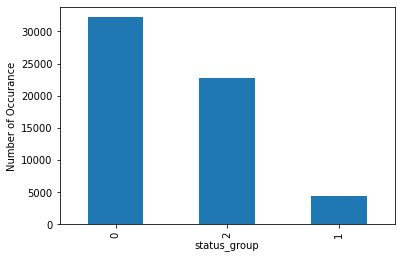

In [1538]:
data.status_group.value_counts().plot.bar()
plt.xlabel('status_group')
plt.ylabel('Number of Occurance')

In [1539]:
# data.info()

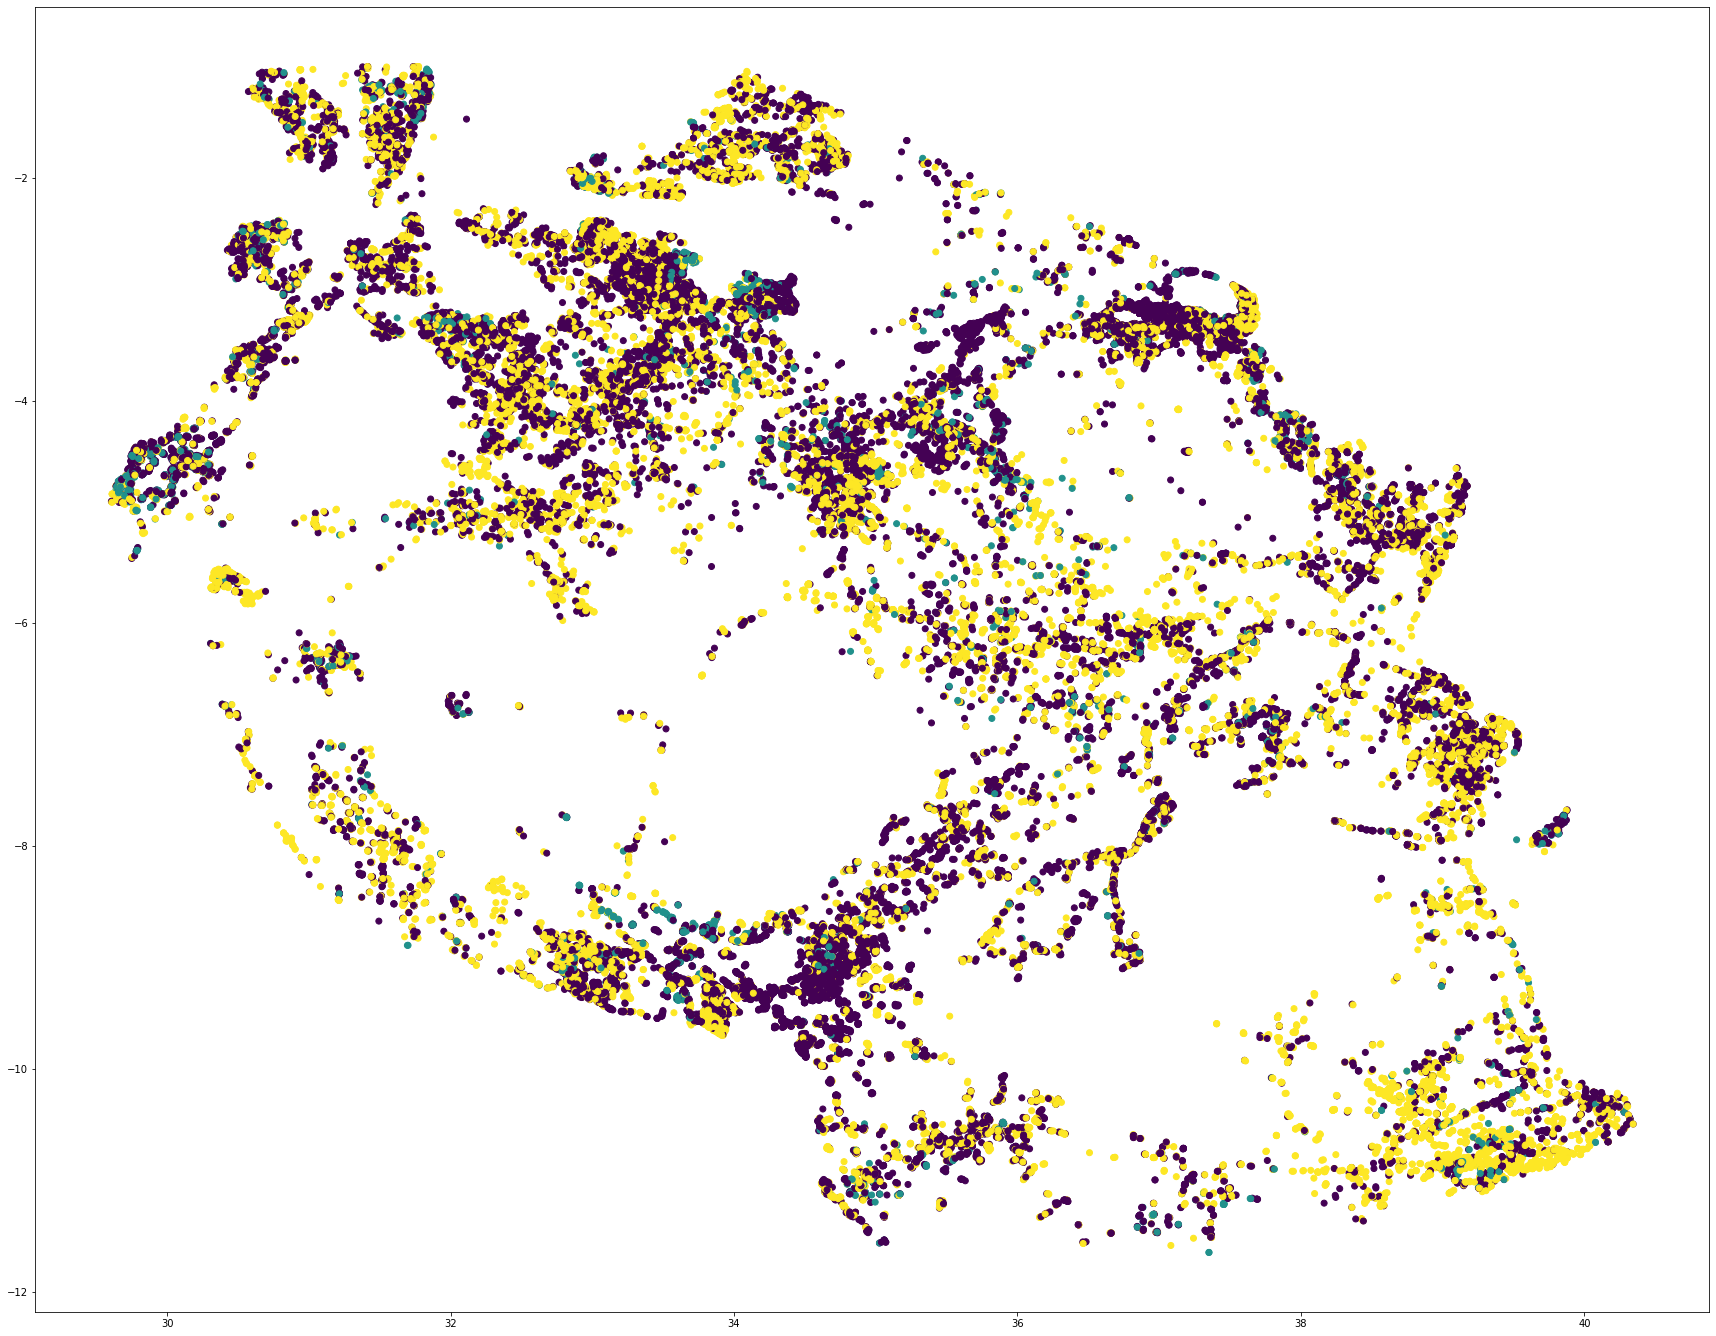

In [1540]:
f, ax = plt.subplots(figsize=(30, 24))
plt.scatter(x=data.longitude, y=data.latitude, c= data.status_group)
plt.show()

#3333 - Saving data for CatBoost

In [1541]:
data.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,imputed_longitude,imputed_latitude,imputed_gps_height,imputed_population,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class
0,69572,6000.0,Rare,1390.0,Rare,34.938093,-9.856322,Missing,Lake Nyasa,Rare,Iringa,11,5,Ludewa,Rare,109.0,Yes,VWC,Rare,No,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0,0,0,0,0,2011,3,0,1,4
1,8776,984.0,Rare,1399.0,Rare,34.698766,-2.147466,Zahanati,Lake Victoria,Rare,Mara,20,2,Serengeti,Rare,280.0,Missing,Rare,missing,Yes,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,0,0,0,0,2013,3,2,1,4
2,34310,25.0,Rare,686.0,world vision,37.460664,-3.821329,Rare,Pangani,Majengo,Manyara,21,4,Rare,Rare,250.0,Yes,VWC,Rare,Yes,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,Rare,Rare,surface,communal standpipe multiple,communal standpipe,0,0,0,0,0,2013,2,0,1,2
3,67743,984.0,Unicef,263.0,Rare,38.486161,-11.155298,Rare,Ruvuma / Southern Coast,Rare,Mtwara,90,63,Rare,Rare,58.0,Yes,VWC,missing,Yes,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,2,0,0,0,0,2013,1,0,1,4
4,19728,984.0,Rare,NaN,Rare,31.130847,-1.825359,Shuleni,Lake Victoria,Rare,Kagera,18,1,Karagwe,Rare,NaN,Yes,Missing,missing,Yes,NaN,gravity,gravity,gravity,Rare,Rare,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,0,0,0,0,2011,7,2,3,0


In [1545]:
variables=['amount_tsh',	'gps_height',	'longitude',	'latitude',	'population',
           'construction_year', 'year_recorded',	'month_recorded',	'day_recorded',
           'quarer_recorded', 'percipitation_class', 'extraction_type', 'funder',
           'region_code', 'district_code', 'lga', 'installer', 'wpt_name',
           'subvillage', 'ward', 'scheme_name','basin', 'region', 'public_meeting', 'permit',
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type', 
               'waterpoint_type_group',
               'scheme_management','status_group']

In [1546]:
CB_data = data[variables]
CB_data.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,extraction_type,funder,region_code,district_code,lga,installer,wpt_name,subvillage,ward,scheme_name,basin,region,public_meeting,permit,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,scheme_management,status_group
0,6000.0,1390.0,34.938093,-9.856322,109.0,1999.0,2011,3,0,1,4,gravity,Rare,11,5,Ludewa,Rare,Missing,Rare,Rare,Rare,Lake Nyasa,Iringa,Yes,No,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,VWC,0
1,984.0,1399.0,34.698766,-2.147466,280.0,2010.0,2013,3,2,1,4,gravity,Rare,20,2,Serengeti,Rare,Zahanati,Rare,Rare,missing,Lake Victoria,Mara,Missing,Yes,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Rare,0
2,25.0,686.0,37.460664,-3.821329,250.0,2009.0,2013,2,0,1,2,gravity,Rare,21,4,Rare,world vision,Rare,Majengo,Rare,Rare,Pangani,Manyara,Yes,Yes,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,Rare,Rare,surface,communal standpipe multiple,communal standpipe,VWC,0
3,984.0,263.0,38.486161,-11.155298,58.0,1986.0,2013,1,0,1,4,submersible,Unicef,90,63,Rare,Rare,Rare,Rare,Rare,missing,Ruvuma / Southern Coast,Mtwara,Yes,Yes,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,VWC,2
4,984.0,NaN,31.130847,-1.825359,NaN,NaN,2011,7,2,3,0,gravity,Rare,18,1,Karagwe,Rare,Shuleni,Rare,Rare,missing,Lake Victoria,Kagera,Yes,Yes,gravity,gravity,Rare,Rare,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Missing,0


In [1547]:
CB_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   gps_height             38962 non-null  float64
 2   longitude              57588 non-null  float64
 3   latitude               57588 non-null  float64
 4   population             38019 non-null  float64
 5   construction_year      38691 non-null  float64
 6   year_recorded          59400 non-null  int64  
 7   month_recorded         59400 non-null  int64  
 8   day_recorded           59400 non-null  int64  
 9   quarer_recorded        59400 non-null  int64  
 10  percipitation_class    59400 non-null  int64  
 11  extraction_type        59400 non-null  object 
 12  funder                 59400 non-null  object 
 13  region_code            59400 non-null  object 
 14  district_code          59400 non-null  object 
 15  lg

#3.2- Target Value Encoding for Categorical Features

https://towardsdatascience.com/target-encoding-for-multi-class-classification-c9a7bcb1a53

###3.2.1- Explore original relationship between categorical variables and target

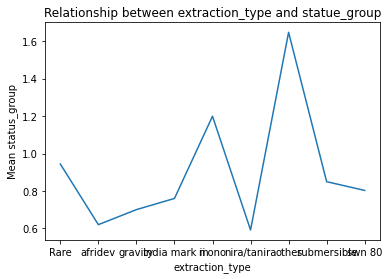

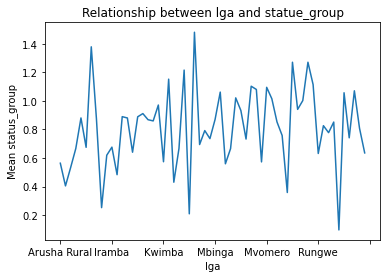

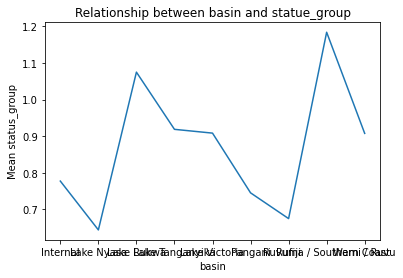

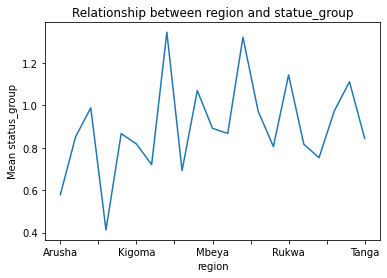

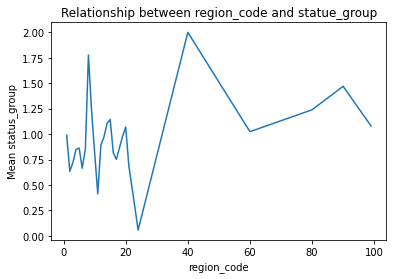

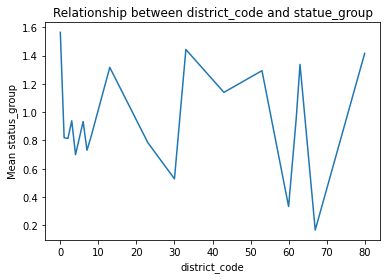

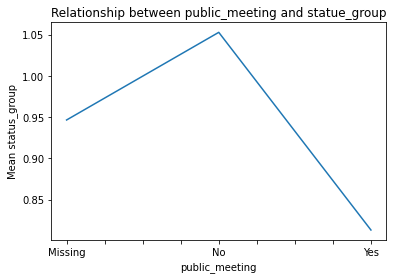

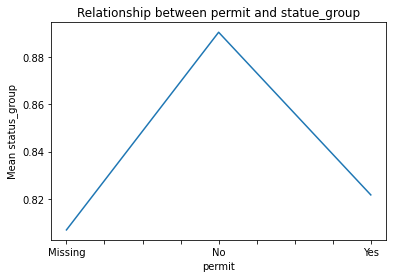

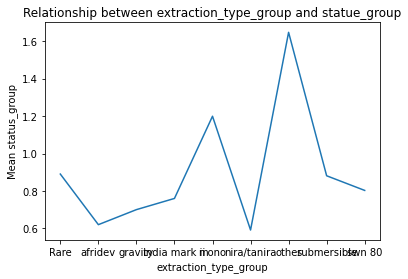

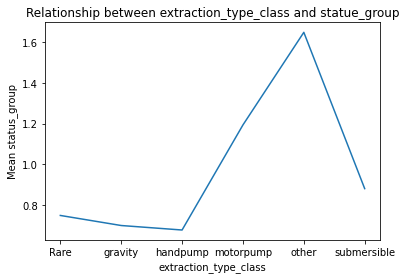

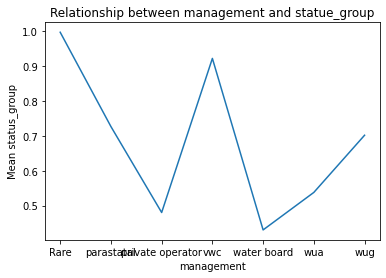

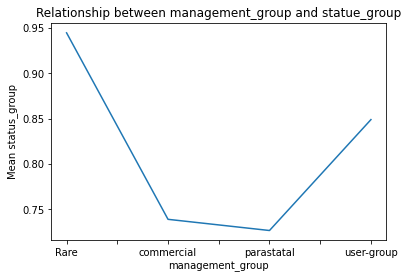

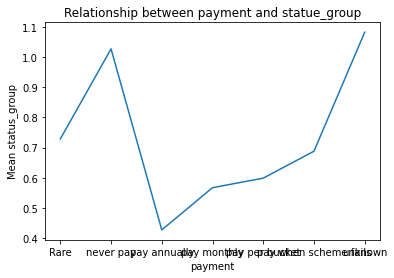

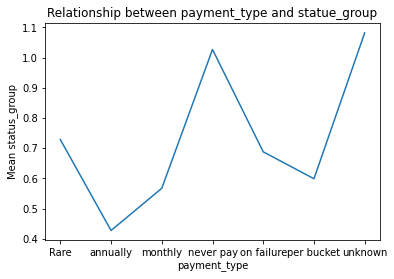

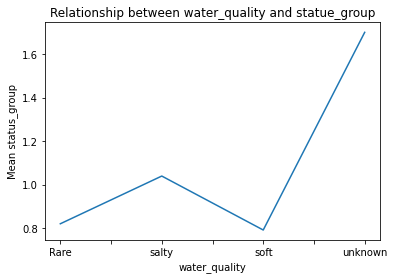

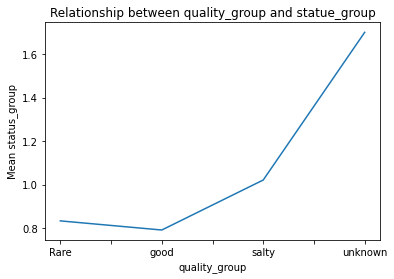

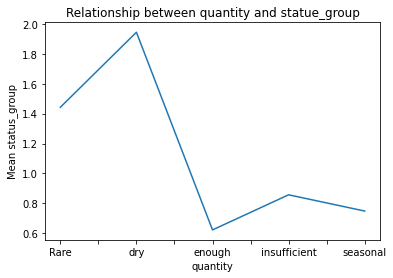

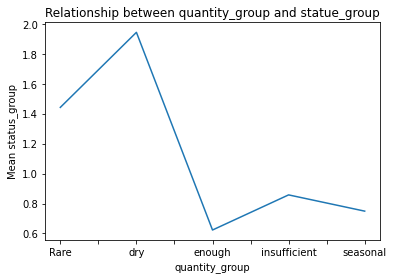

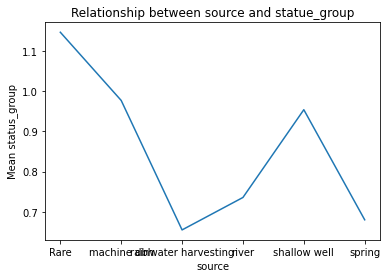

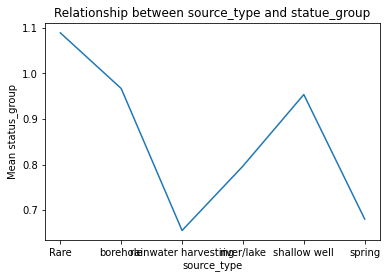

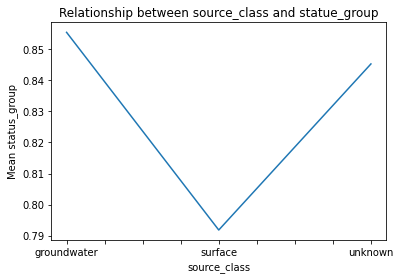

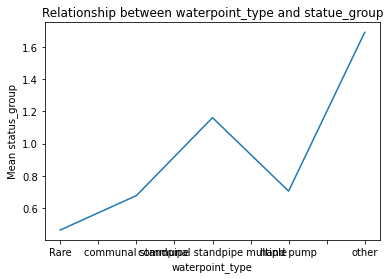

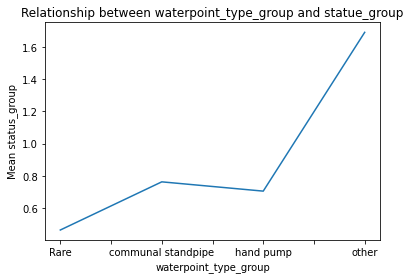

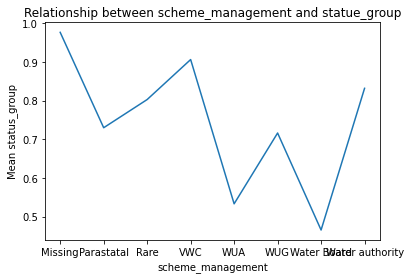

In [1548]:
# let's explore the relationship of the categories with the target

for var in ['extraction_type', 'lga', 'basin', 'region', 'region_code', 'district_code', 'public_meeting', 'permit',
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type', 
               'waterpoint_type_group',
               'scheme_management']:
    
    fig = plt.figure()
    fig = data.groupby([var])['status_group'].mean().plot()
    fig.set_title('Relationship between {} and statue_group'.format(var))
    fig.set_ylabel('Mean status_group')
    plt.show()

###3.2.2- Target Encoding 

https://contrib.scikit-learn.org/category_encoders/


In [1549]:
# pip install category_encoders

In [1550]:
from feature_engine.encoding import MeanEncoder
from category_encoders import OneHotEncoder, TargetEncoder


In [1551]:
data = data.drop(['id'],axis=1)

In [1552]:
status_labels =['func', 'non-func' , 'func_repair']

In [1553]:
enc=OneHotEncoder().fit(data.status_group.astype(str))
status_group_labels=enc.transform(data.status_group.astype(str))
status_group_labels.columns = status_labels
status_group_labels.head()

,func,non-func,func_repair
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,1,0,0


In [1554]:
class_names=status_group_labels.columns[0:2]
class_names


Index(['func', 'non-func'], dtype='object')

In [1555]:
variables=['extraction_type', 'funder', 'region_code', 'district_code', 'lga', 
               'installer', 'wpt_name', 'subvillage', 'ward', 'scheme_name', 
               'basin', 'region', 'public_meeting', 'permit',
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type', 
               'waterpoint_type_group',
               'scheme_management']

In [1556]:
enc=TargetEncoder(smoothing=0)

/usr/local/lib/python3.8/dist-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


In [1557]:
class_names

Index(['func', 'non-func'], dtype='object')

In [1558]:
for var in variables:
  for class_ in class_names:
    enc=TargetEncoder(smoothing=0)
    # print(enc.fit_transform(data,status_group_labels[class_]))
    data[var + '_' + class_] = enc.fit_transform(data[var],status_group_labels[class_])

In [1559]:
data = data.drop(variables,axis=1)

In [1560]:
data.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,status_group,imputed_longitude,imputed_latitude,imputed_gps_height,imputed_population,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,extraction_type_func,extraction_type_non-func,funder_func,funder_non-func,region_code_func,region_code_non-func,district_code_func,district_code_non-func,lga_func,lga_non-func,installer_func,installer_non-func,wpt_name_func,wpt_name_non-func,subvillage_func,subvillage_non-func,ward_func,ward_non-func,scheme_name_func,scheme_name_non-func,basin_func,basin_non-func,region_func,region_non-func,public_meeting_func,public_meeting_non-func,permit_func,permit_non-func,extraction_type_group_func,extraction_type_group_non-func,extraction_type_class_func,extraction_type_class_non-func,management_func,management_non-func,management_group_func,management_group_non-func,payment_func,payment_non-func,payment_type_func,payment_type_non-func,water_quality_func,water_quality_non-func,quality_group_func,quality_group_non-func,quantity_func,quantity_non-func,quantity_group_func,quantity_group_non-func,source_func,source_non-func,source_type_func,source_type_non-func,source_class_func,source_class_non-func,waterpoint_type_func,waterpoint_type_non-func,waterpoint_type_group_func,waterpoint_type_group_non-func,scheme_management_func,scheme_management_non-func
0,6000.0,1390.0,34.938093,-9.856322,109.0,1999.0,0,0,0,0,0,2011,3,0,1,4,0.599253,0.299888,0.603922,0.337531,0.781698,0.195094,0.569100,0.386364,0.774823,0.205674,0.574318,0.370744,0.738142,0.240528,0.544987,0.382558,0.526244,0.399379,0.571487,0.355492,0.653687,0.297148,0.782206,0.194560,0.556899,0.370195,0.517094,0.407443,0.599253,0.299888,0.599253,0.299888,0.504234,0.426864,0.538236,0.387350,0.752334,0.179846,0.752334,0.179846,0.565941,0.357236,0.565941,0.357236,0.652323,0.275357,0.652323,0.275357,0.622290,0.302744,0.622290,0.302744,0.542320,0.397825,0.621485,0.299278,0.576491,0.339523,0.515315,0.421249
1,984.0,1399.0,34.698766,-2.147466,280.0,2010.0,0,0,0,0,0,2013,3,2,1,4,0.599253,0.299888,0.603922,0.337531,0.449975,0.519553,0.555178,0.369283,0.592179,0.370112,0.574318,0.370744,0.518072,0.387952,0.544987,0.382558,0.526244,0.399379,0.514379,0.414471,0.497658,0.405835,0.449975,0.519553,0.503299,0.449910,0.554437,0.376145,0.599253,0.299888,0.599253,0.299888,0.599540,0.301458,0.538236,0.387350,0.448911,0.475856,0.448911,0.475856,0.565941,0.357236,0.565941,0.357236,0.523234,0.380924,0.523234,0.380924,0.603922,0.259259,0.603922,0.259259,0.545168,0.336960,0.621485,0.299278,0.576491,0.339523,0.584314,0.386928
2,25.0,686.0,37.460664,-3.821329,250.0,2009.0,0,0,0,0,0,2013,2,0,1,2,0.599253,0.299888,0.603922,0.337531,0.623500,0.315856,0.621736,0.321702,0.473133,0.475659,0.625179,0.247496,0.532528,0.392061,0.466135,0.462151,0.526244,0.399379,0.571487,0.355492,0.600895,0.345749,0.623500,0.315856,0.556899,0.370195,0.554437,0.376145,0.599253,0.299888,0.599253,0.299888,0.504234,0.426864,0.538236,0.387350,0.677796,0.276683,0.677796,0.276683,0.565941,0.357236,0.565941,0.357236,0.652323,0.275357,0.652323,0.275357,0.415857,0.561601,0.440043,0.528908,0.545168,0.336960,0.366213,0.527609,0.576491,0.339523,0.515315,0.421249
3,984.0,263.0,38.486161,-11.155298,58.0,1986.0,2,0,0,0,0,2013,1,0,1,4,0.551217,0.401134,0.567644,0.338694,0.211559,0.681570,0.317949,0.656410,0.473133,0.475659,0.574318,0.370744,0.532528,0.392061,0.544987,0.382558,0.526244,0.399379,0.514379,0.414471,0.371689,0.555753,0.302890,0.624277,0.556899,0.370195,0.554437,0.376145,0.538760,0.420295,0.538760,0.420295,0.504234,0.426864,0.538236,0.387350,0.448911,0.475856,0.448911,0.475856,0.565941,0.357236,0.565941,0.357236,0.025136,0.968940,0.025136,0.968940,0.489571,0.466095,0.495355,0.462131,0.542320,0.397825,0.366213,0.527609,0.576491,0.339523,0.515315,0.421249
4,984.0,NaN,31.130847,-1.825359,NaN,NaN,0,0,0,0,0,2011,7,2,3,0,0.599253,0.299888,0.603922,0.337531,0.520156,0.388387,0.537409,0.357125,0.530480,0.411154,0.574318,0.370

In [1561]:
# mean_enc = MeanEncoder(
#     variables=['extraction_type', 'funder', 'region_code', 'district_code', 'lga', 'installer', 'wpt_name', 'subvillage', 'ward', 'scheme_name', 'basin', 'region', 'public_meeting', 'permit',
#                'extraction_type_group', 'extraction_type_class', 'management', 
#                'management_group', 'payment', 'payment_type', 'water_quality',
#                'quality_group', 'quantity', 'quantity_group', 'source', 
#                'source_type', 'source_class', 'waterpoint_type', 
#                'waterpoint_type_group',
#                'scheme_management'])

In [1562]:
# mean_enc.fit(data, data.status_group)

In [1563]:
# mean_enc.encoder_dict_

In [1564]:
# mean_enc.variables_

In [1565]:
# data = mean_enc.transform(data)
# X_test = mean_enc.transform(X_test)

# let's explore the result
# data.head()

In [1566]:
# let's inspect the newly created monotonic relationship
# between the variables and the target

# for var in ['extraction_type', 'funder', 'region_code', 'district_code', 'lga', 'installer', 'wpt_name', 'subvillage', 'ward', 'scheme_name', 'basin', 'region', 'public_meeting', 'permit',
#                'extraction_type_group', 'extraction_type_class', 'management', 
#                'management_group', 'payment', 'payment_type', 'water_quality',
#                'quality_group', 'quantity', 'quantity_group', 'source', 
#                'source_type', 'source_class', 'waterpoint_type', 
#                'waterpoint_type_group',
#                'scheme_management']:
    
#     fig = plt.figure()
#     fig = data.groupby([var])['status_group'].mean().plot()
#     fig.set_title('Monotonic relationship between {} and Survival'.format(var))
#     fig.set_ylabel('Mean Survived')
#     plt.show()

#4.0- Multivariate missing value imputation for longitude, latitude, gps_height, population, and construction_year feature
KNN; The missing values are estimated as the average value from the closest K neighbours.

https://github.com/solegalli/feature-engineering-for-machine-learning/blob/main/Section-05-Multivariate-Imputation/05.01-KNN-imputation.ipynb

https://github.com/solegalli/feature-engineering-for-machine-learning/blob/main/Section-05-Multivariate-Imputation/05.02-MICE.ipynb

For imputing missing values in categorical variables, we have to encode the categorical values into numeric values as kNNImputer works only for numeric variables. 

In [1567]:
from sklearn.impute import KNNImputer

In [1568]:
imputer = KNNImputer(
    n_neighbors=5, # the number of neighbours K
    weights='distance', # the weighting factor
    metric='nan_euclidean', # the metric to find the neighbours
    add_indicator=False, # whether to add a missing indicator
)

In [1569]:
data.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,status_group,imputed_longitude,imputed_latitude,imputed_gps_height,imputed_population,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,extraction_type_func,extraction_type_non-func,funder_func,funder_non-func,region_code_func,region_code_non-func,district_code_func,district_code_non-func,lga_func,lga_non-func,installer_func,installer_non-func,wpt_name_func,wpt_name_non-func,subvillage_func,subvillage_non-func,ward_func,ward_non-func,scheme_name_func,scheme_name_non-func,basin_func,basin_non-func,region_func,region_non-func,public_meeting_func,public_meeting_non-func,permit_func,permit_non-func,extraction_type_group_func,extraction_type_group_non-func,extraction_type_class_func,extraction_type_class_non-func,management_func,management_non-func,management_group_func,management_group_non-func,payment_func,payment_non-func,payment_type_func,payment_type_non-func,water_quality_func,water_quality_non-func,quality_group_func,quality_group_non-func,quantity_func,quantity_non-func,quantity_group_func,quantity_group_non-func,source_func,source_non-func,source_type_func,source_type_non-func,source_class_func,source_class_non-func,waterpoint_type_func,waterpoint_type_non-func,waterpoint_type_group_func,waterpoint_type_group_non-func,scheme_management_func,scheme_management_non-func
0,6000.0,1390.0,34.938093,-9.856322,109.0,1999.0,0,0,0,0,0,2011,3,0,1,4,0.599253,0.299888,0.603922,0.337531,0.781698,0.195094,0.569100,0.386364,0.774823,0.205674,0.574318,0.370744,0.738142,0.240528,0.544987,0.382558,0.526244,0.399379,0.571487,0.355492,0.653687,0.297148,0.782206,0.194560,0.556899,0.370195,0.517094,0.407443,0.599253,0.299888,0.599253,0.299888,0.504234,0.426864,0.538236,0.387350,0.752334,0.179846,0.752334,0.179846,0.565941,0.357236,0.565941,0.357236,0.652323,0.275357,0.652323,0.275357,0.622290,0.302744,0.622290,0.302744,0.542320,0.397825,0.621485,0.299278,0.576491,0.339523,0.515315,0.421249
1,984.0,1399.0,34.698766,-2.147466,280.0,2010.0,0,0,0,0,0,2013,3,2,1,4,0.599253,0.299888,0.603922,0.337531,0.449975,0.519553,0.555178,0.369283,0.592179,0.370112,0.574318,0.370744,0.518072,0.387952,0.544987,0.382558,0.526244,0.399379,0.514379,0.414471,0.497658,0.405835,0.449975,0.519553,0.503299,0.449910,0.554437,0.376145,0.599253,0.299888,0.599253,0.299888,0.599540,0.301458,0.538236,0.387350,0.448911,0.475856,0.448911,0.475856,0.565941,0.357236,0.565941,0.357236,0.523234,0.380924,0.523234,0.380924,0.603922,0.259259,0.603922,0.259259,0.545168,0.336960,0.621485,0.299278,0.576491,0.339523,0.584314,0.386928
2,25.0,686.0,37.460664,-3.821329,250.0,2009.0,0,0,0,0,0,2013,2,0,1,2,0.599253,0.299888,0.603922,0.337531,0.623500,0.315856,0.621736,0.321702,0.473133,0.475659,0.625179,0.247496,0.532528,0.392061,0.466135,0.462151,0.526244,0.399379,0.571487,0.355492,0.600895,0.345749,0.623500,0.315856,0.556899,0.370195,0.554437,0.376145,0.599253,0.299888,0.599253,0.299888,0.504234,0.426864,0.538236,0.387350,0.677796,0.276683,0.677796,0.276683,0.565941,0.357236,0.565941,0.357236,0.652323,0.275357,0.652323,0.275357,0.415857,0.561601,0.440043,0.528908,0.545168,0.336960,0.366213,0.527609,0.576491,0.339523,0.515315,0.421249
3,984.0,263.0,38.486161,-11.155298,58.0,1986.0,2,0,0,0,0,2013,1,0,1,4,0.551217,0.401134,0.567644,0.338694,0.211559,0.681570,0.317949,0.656410,0.473133,0.475659,0.574318,0.370744,0.532528,0.392061,0.544987,0.382558,0.526244,0.399379,0.514379,0.414471,0.371689,0.555753,0.302890,0.624277,0.556899,0.370195,0.554437,0.376145,0.538760,0.420295,0.538760,0.420295,0.504234,0.426864,0.538236,0.387350,0.448911,0.475856,0.448911,0.475856,0.565941,0.357236,0.565941,0.357236,0.025136,0.968940,0.025136,0.968940,0.489571,0.466095,0.495355,0.462131,0.542320,0.397825,0.366213,0.527609,0.576491,0.339523,0.515315,0.421249
4,984.0,NaN,31.130847,-1.825359,NaN,NaN,0,0,0,0,0,2011,7,2,3,0,0.599253,0.299888,0.603922,0.337531,0.520156,0.388387,0.537409,0.357125,0.530480,0.411154,0.574318,0.370

In [1570]:
data.construction_year.isnull().sum()

20709

In [1571]:
data.longitude.isnull().sum()

1812

In [1572]:
data.gps_height.isnull().sum()

20438

In [1573]:
# construction_year_zero_index

In [1574]:
KNN_imputer_data = data.drop(['status_group'],axis=1)

In [1575]:
imputer.fit(KNN_imputer_data)

KNNImputer(weights='distance')

In [1576]:
train_t = imputer.transform(KNN_imputer_data)
# test_t = imputer.transform(X_test)

# sklearn returns a Numpy array
# lets make a dataframe
train_t = pd.DataFrame(train_t, columns=KNN_imputer_data.columns)
# test_t = pd.DataFrame(test_t, columns=X_test.columns)

train_t.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,imputed_longitude,imputed_latitude,imputed_gps_height,imputed_population,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,extraction_type_func,extraction_type_non-func,funder_func,funder_non-func,region_code_func,region_code_non-func,district_code_func,district_code_non-func,lga_func,lga_non-func,installer_func,installer_non-func,wpt_name_func,wpt_name_non-func,subvillage_func,subvillage_non-func,ward_func,ward_non-func,scheme_name_func,scheme_name_non-func,basin_func,basin_non-func,region_func,region_non-func,public_meeting_func,public_meeting_non-func,permit_func,permit_non-func,extraction_type_group_func,extraction_type_group_non-func,extraction_type_class_func,extraction_type_class_non-func,management_func,management_non-func,management_group_func,management_group_non-func,payment_func,payment_non-func,payment_type_func,payment_type_non-func,water_quality_func,water_quality_non-func,quality_group_func,quality_group_non-func,quantity_func,quantity_non-func,quantity_group_func,quantity_group_non-func,source_func,source_non-func,source_type_func,source_type_non-func,source_class_func,source_class_non-func,waterpoint_type_func,waterpoint_type_non-func,waterpoint_type_group_func,waterpoint_type_group_non-func,scheme_management_func,scheme_management_non-func
0,6000.0,1390.000000,34.938093,-9.856322,109.00000,1999.000000,0.0,0.0,0.0,0.0,2011.0,3.0,0.0,1.0,4.0,0.599253,0.299888,0.603922,0.337531,0.781698,0.195094,0.569100,0.386364,0.774823,0.205674,0.574318,0.370744,0.738142,0.240528,0.544987,0.382558,0.526244,0.399379,0.571487,0.355492,0.653687,0.297148,0.782206,0.194560,0.556899,0.370195,0.517094,0.407443,0.599253,0.299888,0.599253,0.299888,0.504234,0.426864,0.538236,0.387350,0.752334,0.179846,0.752334,0.179846,0.565941,0.357236,0.565941,0.357236,0.652323,0.275357,0.652323,0.275357,0.622290,0.302744,0.622290,0.302744,0.542320,0.397825,0.621485,0.299278,0.576491,0.339523,0.515315,0.421249
1,984.0,1399.000000,34.698766,-2.147466,280.00000,2010.000000,0.0,0.0,0.0,0.0,2013.0,3.0,2.0,1.0,4.0,0.599253,0.299888,0.603922,0.337531,0.449975,0.519553,0.555178,0.369283,0.592179,0.370112,0.574318,0.370744,0.518072,0.387952,0.544987,0.382558,0.526244,0.399379,0.514379,0.414471,0.497658,0.405835,0.449975,0.519553,0.503299,0.449910,0.554437,0.376145,0.599253,0.299888,0.599253,0.299888,0.599540,0.301458,0.538236,0.387350,0.448911,0.475856,0.448911,0.475856,0.565941,0.357236,0.565941,0.357236,0.523234,0.380924,0.523234,0.380924,0.603922,0.259259,0.603922,0.259259,0.545168,0.336960,0.621485,0.299278,0.576491,0.339523,0.584314,0.386928
2,25.0,686.000000,37.460664,-3.821329,250.00000,2009.000000,0.0,0.0,0.0,0.0,2013.0,2.0,0.0,1.0,2.0,0.599253,0.299888,0.603922,0.337531,0.623500,0.315856,0.621736,0.321702,0.473133,0.475659,0.625179,0.247496,0.532528,0.392061,0.466135,0.462151,0.526244,0.399379,0.571487,0.355492,0.600895,0.345749,0.623500,0.315856,0.556899,0.370195,0.554437,0.376145,0.599253,0.299888,0.599253,0.299888,0.504234,0.426864,0.538236,0.387350,0.677796,0.276683,0.677796,0.276683,0.565941,0.357236,0.565941,0.357236,0.652323,0.275357,0.652323,0.275357,0.415857,0.561601,0.440043,0.528908,0.545168,0.336960,0.366213,0.527609,0.576491,0.339523,0.515315,0.421249
3,984.0,263.000000,38.486161,-11.155298,58.00000,1986.000000,0.0,0.0,0.0,0.0,2013.0,1.0,0.0,1.0,4.0,0.551217,0.401134,0.567644,0.338694,0.211559,0.681570,0.317949,0.656410,0.473133,0.475659,0.574318,0.370744,0.532528,0.392061,0.544987,0.382558,0.526244,0.399379,0.514379,0.414471,0.371689,0.555753,0.302890,0.624277,0.556899,0.370195,0.554437,0.376145,0.538760,0.420295,0.538760,0.420295,0.504234,0.426864,0.538236,0.387350,0.448911,0.475856,0.448911,0.475856,0.565941,0.357236,0.565941,0.357236,0.025136,0.968940,0.025136,0.968940,0.489571,0.466095,0.495355,0.462131,0.542320,0.397825,0.366213,0.527609,0.576491,0.339523,0.515315,0.421249
4,984.0,1238.906857,31.130847,-1.825359,1085.11176,1991.6162

In [1577]:
data.construction_year = train_t.construction_year.round()

In [1579]:
data.longitude = train_t.longitude

In [1580]:
data.latitude = train_t.latitude

In [1581]:
data.gps_height = train_t.gps_height

In [1582]:
data.population = train_t.population

In [1583]:
data['well_age'] = data.year_recorded - data.construction_year

In [1584]:
data.imputed_latitude.isnull().sum()

0

In [1585]:
data.well_age.isnull().sum()

0

In [1586]:
ordinal_encoder = OrdinalEncoder()

In [1587]:
# target_encoder = 

In [1588]:
df_categorical_features = data.select_dtypes(include='object')
df_categorical_features.columns

Index([], dtype='object')

In [1589]:
for i in df_categorical_features.columns:
  data[i] = ordinal_encoder.fit_transform(data[i].values.reshape(-1,1))

In [1590]:
# for i in df_categorical_features.columns:
#   test[i] = ordinal_encoder.fit_transform(test[i].values.reshape(-1,1))

In [1591]:
data.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,status_group,imputed_longitude,imputed_latitude,imputed_gps_height,imputed_population,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,extraction_type_func,extraction_type_non-func,funder_func,funder_non-func,region_code_func,region_code_non-func,district_code_func,district_code_non-func,lga_func,lga_non-func,installer_func,installer_non-func,wpt_name_func,wpt_name_non-func,subvillage_func,subvillage_non-func,ward_func,ward_non-func,scheme_name_func,scheme_name_non-func,basin_func,basin_non-func,region_func,region_non-func,public_meeting_func,public_meeting_non-func,permit_func,permit_non-func,extraction_type_group_func,extraction_type_group_non-func,extraction_type_class_func,extraction_type_class_non-func,management_func,management_non-func,management_group_func,management_group_non-func,payment_func,payment_non-func,payment_type_func,payment_type_non-func,water_quality_func,water_quality_non-func,quality_group_func,quality_group_non-func,quantity_func,quantity_non-func,quantity_group_func,quantity_group_non-func,source_func,source_non-func,source_type_func,source_type_non-func,source_class_func,source_class_non-func,waterpoint_type_func,waterpoint_type_non-func,waterpoint_type_group_func,waterpoint_type_group_non-func,scheme_management_func,scheme_management_non-func,well_age
0,6000.0,1390.000000,34.938093,-9.856322,109.00000,1999.0,0,0,0,0,0,2011,3,0,1,4,0.599253,0.299888,0.603922,0.337531,0.781698,0.195094,0.569100,0.386364,0.774823,0.205674,0.574318,0.370744,0.738142,0.240528,0.544987,0.382558,0.526244,0.399379,0.571487,0.355492,0.653687,0.297148,0.782206,0.194560,0.556899,0.370195,0.517094,0.407443,0.599253,0.299888,0.599253,0.299888,0.504234,0.426864,0.538236,0.387350,0.752334,0.179846,0.752334,0.179846,0.565941,0.357236,0.565941,0.357236,0.652323,0.275357,0.652323,0.275357,0.622290,0.302744,0.622290,0.302744,0.542320,0.397825,0.621485,0.299278,0.576491,0.339523,0.515315,0.421249,12.0
1,984.0,1399.000000,34.698766,-2.147466,280.00000,2010.0,0,0,0,0,0,2013,3,2,1,4,0.599253,0.299888,0.603922,0.337531,0.449975,0.519553,0.555178,0.369283,0.592179,0.370112,0.574318,0.370744,0.518072,0.387952,0.544987,0.382558,0.526244,0.399379,0.514379,0.414471,0.497658,0.405835,0.449975,0.519553,0.503299,0.449910,0.554437,0.376145,0.599253,0.299888,0.599253,0.299888,0.599540,0.301458,0.538236,0.387350,0.448911,0.475856,0.448911,0.475856,0.565941,0.357236,0.565941,0.357236,0.523234,0.380924,0.523234,0.380924,0.603922,0.259259,0.603922,0.259259,0.545168,0.336960,0.621485,0.299278,0.576491,0.339523,0.584314,0.386928,3.0
2,25.0,686.000000,37.460664,-3.821329,250.00000,2009.0,0,0,0,0,0,2013,2,0,1,2,0.599253,0.299888,0.603922,0.337531,0.623500,0.315856,0.621736,0.321702,0.473133,0.475659,0.625179,0.247496,0.532528,0.392061,0.466135,0.462151,0.526244,0.399379,0.571487,0.355492,0.600895,0.345749,0.623500,0.315856,0.556899,0.370195,0.554437,0.376145,0.599253,0.299888,0.599253,0.299888,0.504234,0.426864,0.538236,0.387350,0.677796,0.276683,0.677796,0.276683,0.565941,0.357236,0.565941,0.357236,0.652323,0.275357,0.652323,0.275357,0.415857,0.561601,0.440043,0.528908,0.545168,0.336960,0.366213,0.527609,0.576491,0.339523,0.515315,0.421249,4.0
3,984.0,263.000000,38.486161,-11.155298,58.00000,1986.0,2,0,0,0,0,2013,1,0,1,4,0.551217,0.401134,0.567644,0.338694,0.211559,0.681570,0.317949,0.656410,0.473133,0.475659,0.574318,0.370744,0.532528,0.392061,0.544987,0.382558,0.526244,0.399379,0.514379,0.414471,0.371689,0.555753,0.302890,0.624277,0.556899,0.370195,0.554437,0.376145,0.538760,0.420295,0.538760,0.420295,0.504234,0.426864,0.538236,0.387350,0.448911,0.475856,0.448911,0.475856,0.565941,0.357236,0.565941,0.357236,0.025136,0.968940,0.025136,0.968940,0.489571,0.466095,0.495355,0.462131,0.542320,0.397825,0.366213,0.527609,0.576491,0.339523,0.515315,0.421249,27.0
4,984.0,1238.906857,31.130847,-1.825359,1085.11176,1992.0,0,0,0,0,0,2011,7,2,3,0,0.599253,0.299888,0.603

Correlation Matrix

In [1592]:
# plt.figure(figsize=(10,8))
# cmap=data.corr()
# sns.heatmap(cmap)

##4.1- water_per_person
We engineer this feature by dividing the amount_tsh by population around the well.

In [1593]:
data['water_per_person']=data.amount_tsh/data.population

##4.2- ave_pop
We engineer this feature by dividing average pop served per year feature

In [1594]:
# features['pop/year'] = features['population'] / features['age']

#3333 - Saving data for CatBoost adding the new ones and replacing with the KNN results

In [1597]:
CB_data[['construction_year', 'longitude', 'latitude', 'gps_height', 'population']] = data[['construction_year', 'longitude', 'latitude', 'gps_height', 'population']]
CB_data['well_age'] = data['well_age']

In [1598]:
CB_data.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,extraction_type,funder,region_code,district_code,lga,installer,wpt_name,subvillage,ward,scheme_name,basin,region,public_meeting,permit,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,scheme_management,status_group,well_age
0,6000.0,1390.000000,34.938093,-9.856322,109.00000,1999.0,2011,3,0,1,4,gravity,Rare,11,5,Ludewa,Rare,Missing,Rare,Rare,Rare,Lake Nyasa,Iringa,Yes,No,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,VWC,0,12.0
1,984.0,1399.000000,34.698766,-2.147466,280.00000,2010.0,2013,3,2,1,4,gravity,Rare,20,2,Serengeti,Rare,Zahanati,Rare,Rare,missing,Lake Victoria,Mara,Missing,Yes,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Rare,0,3.0
2,25.0,686.000000,37.460664,-3.821329,250.00000,2009.0,2013,2,0,1,2,gravity,Rare,21,4,Rare,world vision,Rare,Majengo,Rare,Rare,Pangani,Manyara,Yes,Yes,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,Rare,Rare,surface,communal standpipe multiple,communal standpipe,VWC,0,4.0
3,984.0,263.000000,38.486161,-11.155298,58.00000,1986.0,2013,1,0,1,4,submersible,Unicef,90,63,Rare,Rare,Rare,Rare,Rare,missing,Ruvuma / Southern Coast,Mtwara,Yes,Yes,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,VWC,2,27.0
4,984.0,1238.906857,31.130847,-1.825359,1085.11176,1992.0,2011,7,2,3,0,gravity,Rare,18,1,Karagwe,Rare,Shuleni,Rare,Rare,missing,Lake Victoria,Kagera,Yes,Yes,gravity,gravity,Rare,Rare,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Missing,0,19.0


#3- Train and Test Split and Feature Engineering

In [1120]:
X = data.drop('status_group',axis=1)
Y = data.status_group
# x_test=test.drop('id',axis=1)

In [1121]:
# data.head()

In [1122]:
x_train, x_valid, y_train, y_valid = train_test_split(X,Y, random_state = 0, test_size = 0.1, stratify = Y, shuffle=True)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((53460, 77), (5940, 77), (53460,), (5940,))

###3.1- Transforming features

The classes are imbalanced, used balanced parameter 

In [1123]:
# scaler = StandardScaler().fit(x_train)
# x_train = scaler.transform(x_train)
# x_valid = scaler.transform(x_valid)
# x_test = scaler.transform(x_test) # The final test set

In [883]:
# class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y=y_train)

# class_weights = dict(zip(np.unique(y_train),class_weights))
# class_weights 

# class_weights = dict(zip(np.unique(x_train), class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)))

In [ ]:
# sns.displot(y_val)

In [ ]:
# y_valid.value_counts()

#4- Building Models

##4.1- CatBoost

##4.2- Random Forest 

### 4.2.1- Hyper Parameter Tuning for Random Forest - sequential Approach

####4.2.1.1- Finding the optimum number of iterations, number of stumps
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    decision_stump= [50, 75, 100, 150, 200, 300, 400, 500, 600, 700]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        # models[str(i)] = XGBClassifier(n_estimators=i)

        models[str(i)] = RandomForestClassifier(
                            n_estimators = i,#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            criterion = 'gini', #{“gini”, “entropy”, “log_loss”}, default=”gini”
                            max_depth = None, # the larger the more prone to overfit, range 3-10
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            max_features='sqrt', #{“sqrt”, “log2”, None}, int or float, default=”sqrt”
                            max_leaf_nodes = None, #Grow trees with max_leaf_nodes in best-first fashion. 
                            #Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                            min_impurity_decrease = 0, #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
                            bootstrap = True,
                            warm_start = False, #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                            class_weight = 'balanced',
                            max_samples = None,
                            verbose = 2,
                            n_jobs = -1,
                            random_state = 17,
                            
) 
#     returning the model
    return models

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=17)
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1)  
    # returning the accuracy score
    return accuracy

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    accuracy = evaluate_model(model, x_train, y_train)

    # appending the accuray socres in results
    results.append(accuracy)
    names.append(name)

    # printing -Hyperparameter tuning of XGBoost
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.2.1.2- Finding the optimum criterion

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    criterions= ['gini', 'entropy']
        
#    using for loop to iterate though trees
    for i in criterions:
        
#         building model with specified trees
        # models[str(i)] = XGBClassifier(n_estimators=i)

        models[str(i)] = RandomForestClassifier(
                            n_estimators = 300,
                            criterion = i, #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            max_depth = None, # the larger the more prone to overfit, range 3-10
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            max_features='sqrt', #{“sqrt”, “log2”, None}, int or float, default=”sqrt”
                            max_leaf_nodes = None, #Grow trees with max_leaf_nodes in best-first fashion. 
                            #Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                            min_impurity_decrease = 0, #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
                            bootstrap = True,
                            warm_start = False, #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                            class_weight = 'balanced',
                            max_samples = None,
                            verbose = 2,
                            n_jobs = -1,
                            random_state = 17,
                            
) 
#     returning the model
    return models

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    accuracy = evaluate_model(model, x_train, y_train)

    # appending the accuray socres in results
    results.append(accuracy)
    names.append(name)

    # printing -Hyperparameter tuning of XGBoost
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.2.1.3- Finding the max_features

In [ ]:
x_train.info()

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    Num_features= [1, 2, 3, 4, 5, 6, 'sqrt', 'log2', 7, 8, 9, 10, None]
        
#    using for loop to iterate though trees
    for i in Num_features:
        
#         building model with specified trees
        # models[str(i)] = XGBClassifier(n_estimators=i)

        models[str(i)] = RandomForestClassifier(
                            n_estimators = 300,
                            criterion = 'entropy', 
                            max_depth = None, # the larger the more prone to overfit, range 3-10
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            max_features= i, #{“sqrt”, “log2”, None}, int or float, default=”sqrt”#>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            max_leaf_nodes = None, #Grow trees with max_leaf_nodes in best-first fashion. 
                            #Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                            min_impurity_decrease = 0, #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
                            bootstrap = True,
                            warm_start = False, #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                            class_weight = 'balanced',
                            max_samples = None,
                            verbose = 2,
                            n_jobs = -1,
                            random_state = 17,
                            
) 
#     returning the model
    return models

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    accuracy = evaluate_model(model, x_train, y_train)

    # appending the accuray socres in results
    results.append(accuracy)
    names.append(name)

    # printing -Hyperparameter tuning of XGBoost
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

###4.2.3- RandomizedSearchCV Hyperparameter Tuning for Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [ ]:
# defiing the model
rf_model = RandomForestClassifier(
                            # n_estimators = 300,
                            criterion = 'entropy', 
                            max_depth = None, # 
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            max_features= 'sqrt', #{“sqrt”, “log2”, None}, int or float, default=”sqrt”#>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            max_leaf_nodes = None, #Grow trees with max_leaf_nodes in best-first fashion. 
                            #Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                            min_impurity_decrease = 0, #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
                            bootstrap = True,
                            warm_start = False, #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                            class_weight = 'balanced',
                            max_samples = None,
                            verbose = 2,
                            n_jobs = -1,
                            random_state = 17,
)


# creating a dict of grids
grid = dict()

# values for iteration
grid['n_estimators'] = np.arange(50,900)



In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)


# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = rf_model
                                 , param_distributions=grid
                                 , n_iter=10
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = 2 # None, to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                #  , verbose = 1
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train, y_train)


# printing the best parameters - Hyperparameter tuning of Random Forest
print("Accuracy score: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))

###4.3.3- Fitting the Optimum Random Forest Model

In [1127]:
rf_clf = RandomForestClassifier(
                            n_estimators = 300,
                            criterion = 'entropy', 
                            max_depth = None, # 
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            max_features= 'sqrt', #{“sqrt”, “log2”, None}, int or float, default=”sqrt”
                            max_leaf_nodes = None, #Grow trees with max_leaf_nodes in best-first fashion. 
                            #Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                            min_impurity_decrease = 0, #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
                            bootstrap = True,
                            warm_start = False, #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                            class_weight = 'balanced',
                            max_samples = None,
                            verbose = 1,
                            n_jobs = -1,
                            random_state = 17,
).fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   48.8s finished


####Perform Prediction and Display Results for Random Forest

In [1128]:
rf_preds = rf_clf.predict(x_valid)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.7s finished


              precision    recall  f1-score   support

           0       0.81      0.89      0.85      3226
           1       0.56      0.39      0.46       432
           2       0.85      0.78      0.82      2282

    accuracy                           0.81      5940
   macro avg       0.74      0.69      0.71      5940
weighted avg       0.81      0.81      0.81      5940



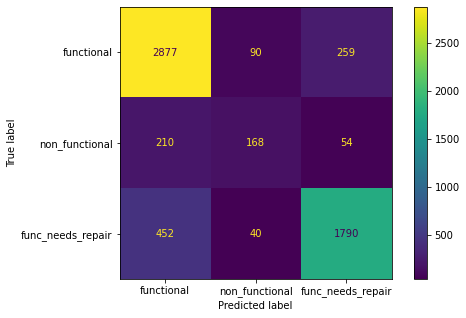

In [1129]:
print(classification_report(y_valid, rf_preds))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, rf_preds),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

####Feature Importance - Random Forest

In [1130]:
rf_feature_scores = pd.Series(rf_clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# feature_scores

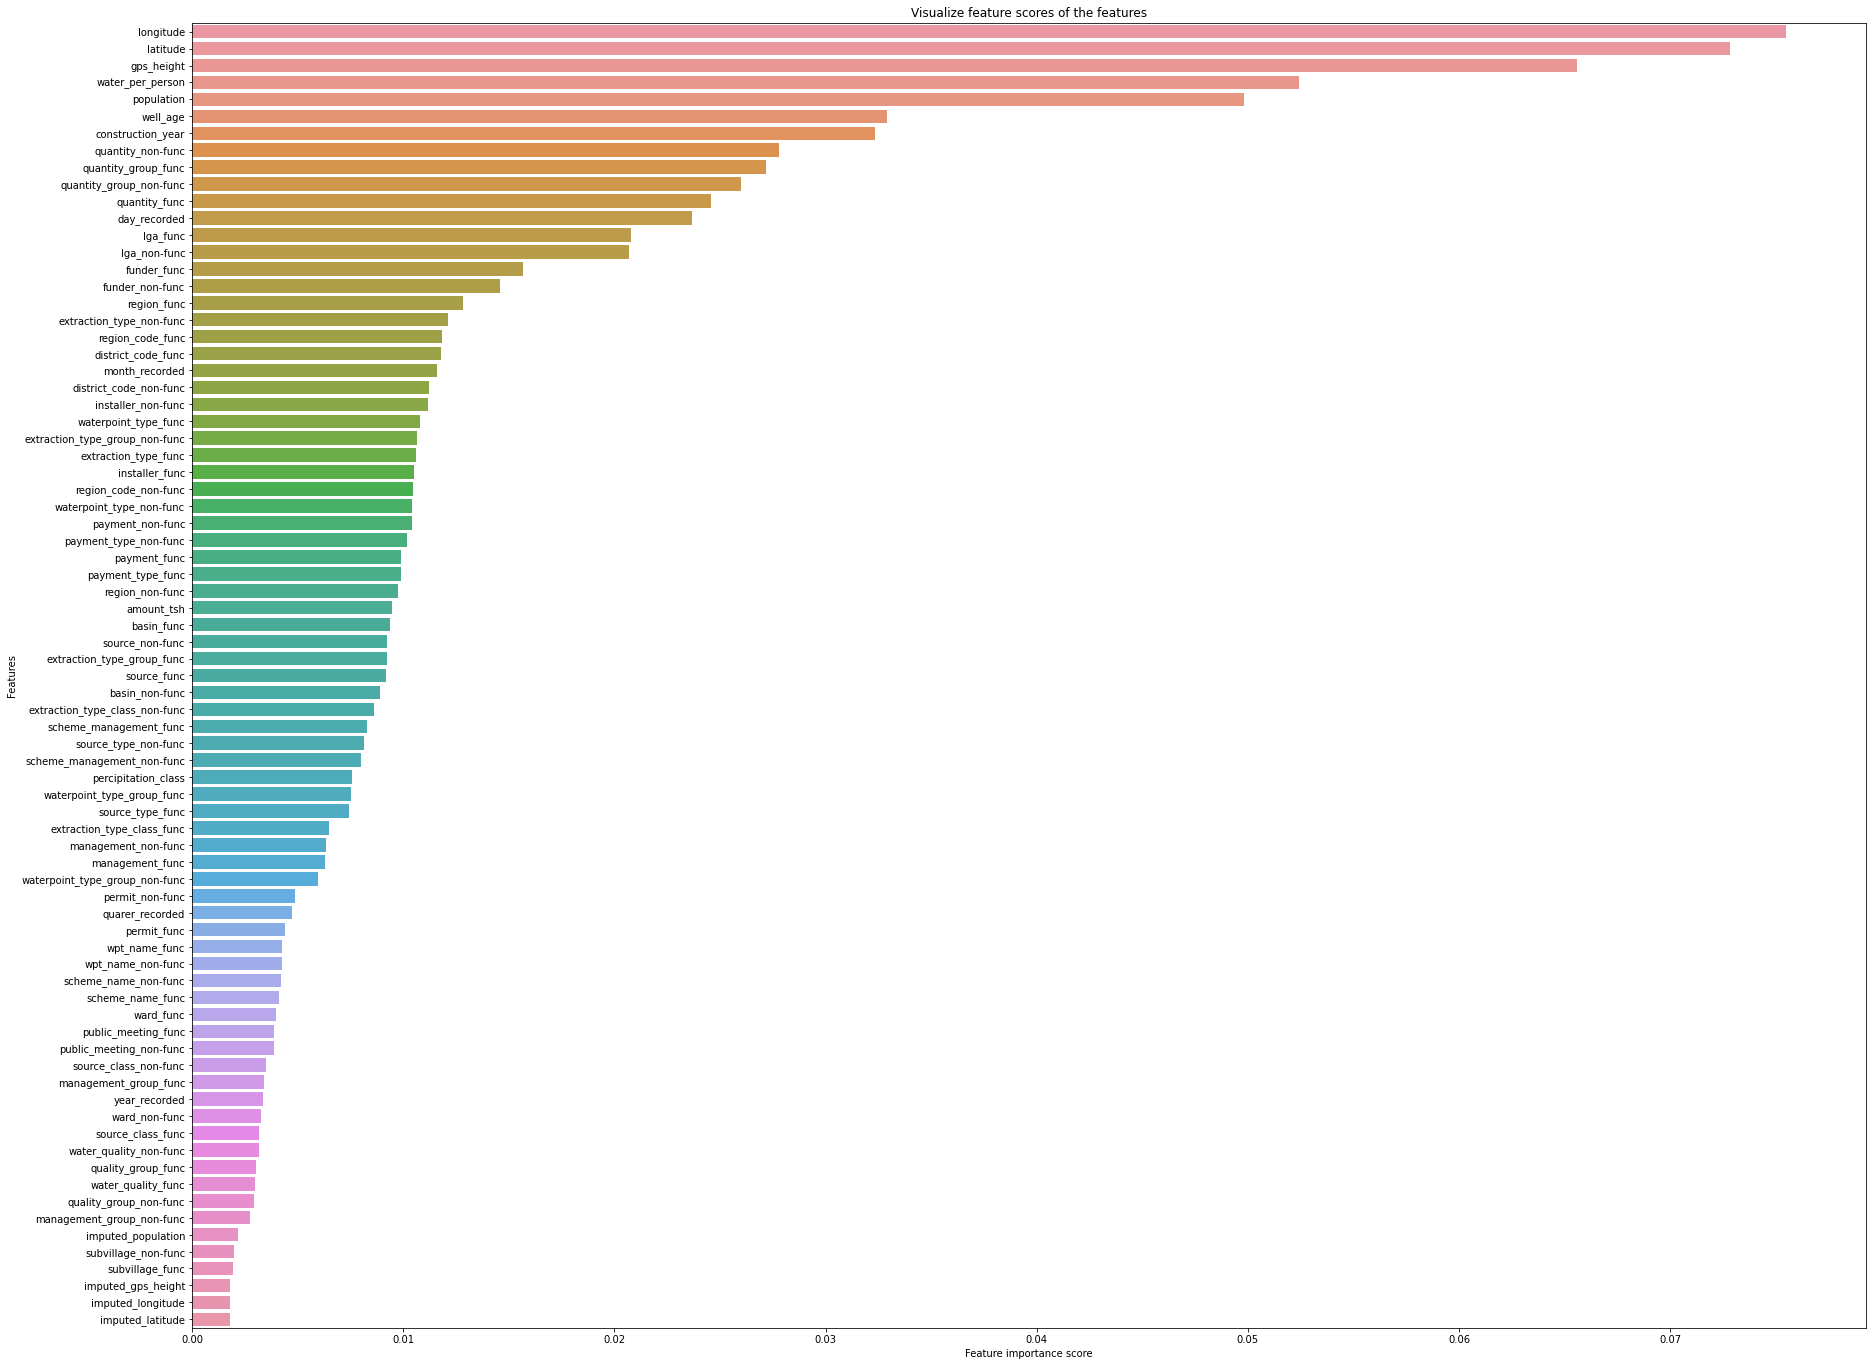

In [1131]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=rf_feature_scores, y=rf_feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(rf_feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

##4.4- eXtreme Gradient boosting
Main features:
* 1- Cross-validation at each iteration: Cross-validation is a process in which the model is tested using different portions of the dataset in each iteration. The XGBoost algorithm has an internal parameter for the cross-validation and it tests each of the weak learners using the cross-validation method.
* 2- Parallel process: XGBoost uses OpenMP for parallel processing. But unlike random forests which create trees in parallel, the XGBoost creates individual trees using a parallel process.
* 3- Regularization: In Machines, learning regularization is a technique that is commonly used to reduce the risk of overfitting. Overfitting is when the models learn too many specific patterns about the training dataset and fail to generalize on the testing dataset. So, the XGBoost uses different regularization techniques in order to make sure that the model is not overfitted and that the findings can be generalized to the testing dataset.
* 4- Missing values: One of the essential features of the XGBoost algorithm is that it can handle the missing values automatically. That means we don’t need to handle missing values in the preprocessing step.
* 5- Tree pruning: Tree pruning is the process of removing the nodes from the trees that do not contribute to the classification.

https://techfor-today.com/hyperparameter-tuning-of-xgboost-algorithm/#Finding_the_optimum_number_of_features_using_Hyperparameter_tuning_of_XGBoost

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

###4.3.1- Hyper Parameter Tuning for eXtreme Gradient Boosting - sequential Approach
1- Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.

2- Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.

3- Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.

4- Lower the learning rate and decide the optimal parameters.

https://kevinvecmanis.io/machine%20learning/hyperparameter%20tuning/dataviz/python/2019/05/11/XGBoost-Tuning-Visual-Guide.html

https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

####4.3.1.1- Finding the optimum number of iterations, number of stumps

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    decision_stump= [100, 150, 200, 300, 400, 500, 600, 700]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        # models[str(i)] = XGBClassifier(n_estimators=i)

        models[str(i)] = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2
                            n_estimators = i,#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.3,
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
                            
) 
#     returning the model
    return models

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=17)
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1)  
    # returning the accuracy score
    return accuracy

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    accuracy = evaluate_model(model, x_train, y_train)

    # appending the accuray socres in results
    results.append(accuracy)
    names.append(name)

    # printing -Hyperparameter tuning of XGBoost
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.3- Finding the optimum sample size

In [ ]:
# creating the function
def build_models():
    
#     dic of models
    models = dict()
    
#     exploring different sample values
    for i in np.arange(0.1, 1.1, 0.1):
        
#         key value
        k = '%.1f' % i
    
#     appending the model
        models[k] = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = i, #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
    return models

In [ ]:
# calling the function
models = {}
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():

    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Samples(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.4- Finding optimum learning rate 

In [ ]:
# creating function
def build_models():
    
#     creating dic of models
    models = dict()
    
#     different learning rates
    for i in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        
#         key value
        k = '%.4f' % i
    
#     appending the models
        models[k] = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = i, # range [0,1], typically=0.01-0.2 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
    return models

In [ ]:
# calling the function
models ={}
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Learning Rate(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

####4.3.1.5- Finding the optimum depth 

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in range(1,13):
        
#         appending the models
        models[str(i)] = XGBClassifier(max_depth = i, # the larger the more prone to overfit, range 3-10 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2 
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
        
#   returining the model
    return models

In [ ]:
# calling the function
models = {}
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Decision tree depth (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

####4.3.1.6- Finding the optimum colsample_bytree

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in np.arange(0, 1.1, 0.1):
        
#         appending the models
        models[str(i)] = XGBClassifier(max_depth = 7, # the larger the more prone to overfit, range 3-10 
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2 
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = i, #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            colsample_bylevel = i,
                            colsample_bynode = i,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
        
#   returining the model
    return models

In [ ]:
# calling the function
models = {}
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Portion of Features Selected - colsample_by (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

####4.3.1.7- Finding the optimum scale_pos_weight

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in np.arange(0.1, 1.1, 0.1):
        
#         appending the models
        models[str(i)] = XGBClassifier(max_depth = 7, # the larger the more prone to overfit, range 3-10 
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2 
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 1, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = 0.5, 
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = i, #[default=1] #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            random_state = 17,
        )
        
#   returining the model
    return models

In [ ]:
# calling the function
models = {}
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('scale_pos_weight - colsample_by (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

###4.3.2- RandomizedSearchCV for Hyperparameter tuning of XGBoost

In [ ]:
# defiing the model
model = XGBClassifier( 
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            colsample_bytree = 0.5, 
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            scale_pos_weight = 0.6, #[default=1] 
                            random_state = 17,)


# creating a dict of grids
grid = dict()

# values for iteration
grid['n_estimators'] = np.arange(400,900)

# values for learning rate
grid['learning_rate'] = [0.08, 0.09, 0.1]

# values for the sample
grid['subsample'] = np.arange(0.3, 0.81, 0.025)

# values for teh depth of tree
grid['max_depth'] = [4, 5, 6, 7, 8, 9, 10]

In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)


# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = model
                                 , param_distributions=grid
                                 , n_iter=10
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = 2 # None, to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                #  , verbose = 1
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train, y_train)


# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))

###4.3.3 Fitting the Optimum Model

In [1132]:
xgboost_clf = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.09, # range [0,1], typically=0.01-0.2
                            n_estimators = 533,
                            verbosity = 1,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 1, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.75,
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
                            
)

In [1133]:
xgboost_clf.fit(x_train,y_train)

XGBClassifier(colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5,
              learning_rate=0.09, max_depth=8, n_estimators=533,
              objective='multi:softprob', random_state=17, scale_pos_weight=0.5,
              subsample=0.75)

In [1134]:
xgboost_preds = xgboost_clf.predict(x_valid)

              precision    recall  f1-score   support

           0       0.81      0.91      0.85      3226
           1       0.60      0.34      0.43       432
           2       0.86      0.78      0.81      2282

    accuracy                           0.82      5940
   macro avg       0.75      0.67      0.70      5940
weighted avg       0.81      0.82      0.81      5940



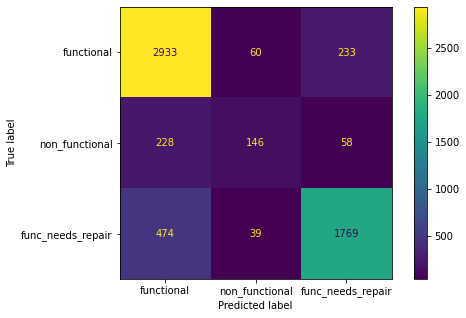

In [1136]:
print(classification_report(y_valid, xgboost_preds))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, xgboost_preds),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [1137]:
xgboost_feature_scores = pd.Series(xgboost_clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# xgboost_feature_scores

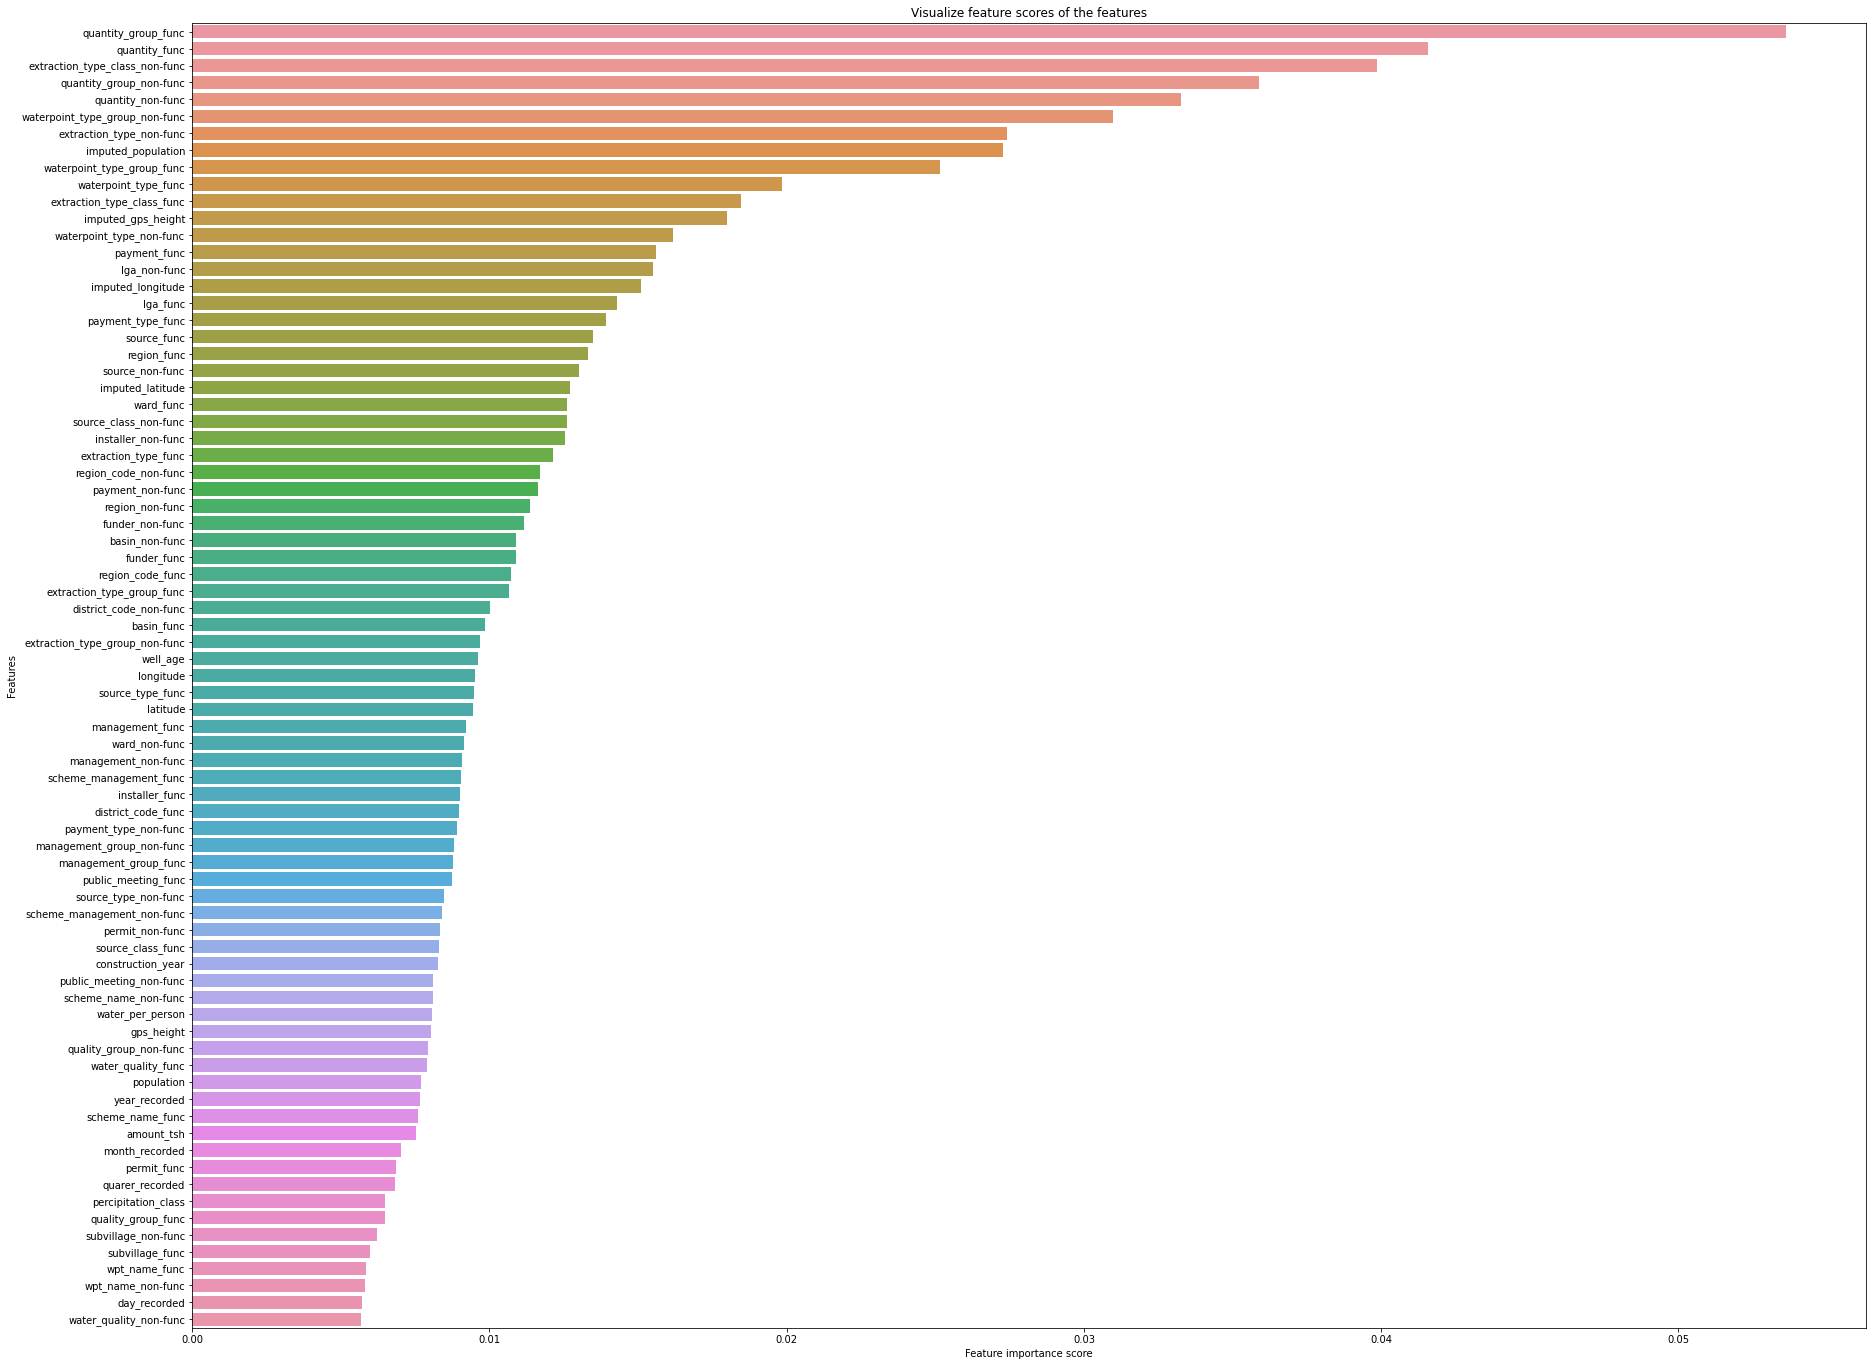

In [1138]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=xgboost_feature_scores, y=xgboost_feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(xgboost_feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

##4.3- Gradient Boosting
Gradient Tree Boosting, Stochastic Gradient Boosting, and GBM are other names for the Gradient Boosting Algorithm. It creates a sequence of weak models ( usually decision trees) and comes up with a final strong learner. Each prediction in gradient boosting aims to outperform the one before it by lowering the errors. Gradient Boosting’s key principle is that it fits a new predictor to the residual errors created by the preceding predictor rather than fitting a prediction to the data at each iteration.

https://techfor-today.com/gradient-boosting-algorithm-using-python/



###4.3.1- Hyper Parameter Tuning for Gradient Boosting

GradientBoostingClassifier(*, loss: str = "deviance", learning_rate: float = 0.1, n_estimators: int = 100, subsample: float = 1, criterion: str = "friedman_mse", min_samples_split: int = 2, min_samples_leaf: int = 1, min_weight_fraction_leaf: float = 0, max_depth: int = 3, min_impurity_decrease: float = 0, init: Any | None = None, random_state: Any | None = None, max_features: Any | None = None, verbose: int = 0, max_leaf_nodes: Any | None = None, warm_start: bool = False, validation_fraction: float = 0.1, n_iter_no_change: Any | None = None, tol: float = 0.0001, ccp_alpha: float = 0)

####4.3.1.1- Finding the optimum number of trees in Gradient boosting

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    GB_models = dict()
    
    # number of decision stumps
    decision_stump= [150, 200, 250, 300]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        GB_models[str(i)] = GradientBoostingClassifier(n_estimators=i)
    
#     returning the model
    return GB_models

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    
    
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1)
    
#     returning the accuracy score
    return accuracy

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    scores = evaluate_model(model, x_train, y_train)
    
    
    # appending the accuray socres in results
    results.append(scores)
    names.append(name)
    
    
    # printing - Gradient boosting algorithm using Python
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(scores)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.2- Finding the optimum depth of trees in the Gradient boosting algorithm using Python

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    GB_models = dict()
    
#     specifying the depth of trees
    for i in range(1,7):
        
#         appending the models
        GB_models[str(i)] = GradientBoostingClassifier(max_depth=i)
        
#   returining the model
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating lists 
results, names = list(), list()
# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Gradient boosting algorithm using Python
    print('---->Decision tree depth (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.3- Finding an optimum Learning rate in Gradient boosting algorithm using Python

In [ ]:
# creating function
def build_models():
    
#     creating dic of models
    GB_models = dict()
    
#     different learning rates
    for i in [0.05, 0.1, 0.2, 0.5, 1.0, 1.5]:
        
#         key value
        k = '%.4f' % i
    
#     appending the models
        GB_models[k] = GradientBoostingClassifier(learning_rate=i)
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing learning rate of Gradient boosting algorithm using Python
    print('---->Learning Rate(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.4- Finding an optimum number of features in the Gradient boosting algorithm using Python
Each decision tree can have a different amount of attributes that are utilized to suit it. Similar to modifying the sample size, changing the number of features gives more variance to the model, which may enhance performance.

In [ ]:
# creating the function 
def build_models():
    
#     creating dic of models
    GB_models = dict()
    
    # explore features numbers from 1-4
    for i in range(1,5):
        
#         appending the models
        GB_models[str(i)] = GradientBoostingClassifier(max_features=i)
    
#     returining the models
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing features of Gradient boosting algorithm using Python
    print('---->Features(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.4- Finding the optimum number of samples in the Gradient boosting algorithm using Python
You can change how many samples were used to fit each tree. This indicates that a randomly chosen portion of the training dataset is used to fit each tree. Using fewer samples introduces more variance for each tree, although it can improve the overall performance of the model. Let us now create a function that returns multiple models with different sample values.

In [ ]:
# creating the function
def build_models():
    
#     dic of models
    GB_models = dict()
    
#     exploring different sample values
    for i in np.arange(0.1, 1.1, 0.1):
        
#         key value
        k = '%.1f' % i
    
#     appending the model
        GB_models[k] = GradientBoostingClassifier(subsample=i)
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing sampes for Gradient boosting algorithm using Python
    print('---->Samples(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

###4.3.2- GridSearchCV for Gradient boosting algorithm using Python

In [ ]:
# defiing the model
model = GradientBoostingClassifier()
# creating a dict of grids
grid = dict()
# values for iteration
grid['n_estimators'] = [10, 50, 100, 500]
# values for learning rate
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# values for the sampel
grid['subsample'] = [0.5, 0.7, 1.0]
# values for teh depth of tree
grid['max_depth'] = [3, 4, 5]

In [ ]:
# defining the cv
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# applying the gridsearchcv method
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# storing the values
grid_result = grid_search.fit(x_train, y_train)
# printing the best parameters of Gradient boosting algorithm using Python
print("Accuracy score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

###4.3.3- Fitting the Optimum Mode

##4.4- ADABoostClassifier
The training algorithm involves starting with one decision tree, finding those examples in the training dataset that were misclassified, and adding more weight to those examples. Another tree is trained on the same data, although now weighted by the misclassification errors. This process is repeated until a desired number of trees are added.

https://machinelearningmastery.com/adaboost-ensemble-in-python/

https://www.datacamp.com/tutorial/adaboost-classifier-python#adaboost-classifier

https://towardsdatascience.com/the-ultimate-guide-to-adaboost-random-forests-and-xgboost-7f9327061c4f

https://vitalflux.com/differences-between-random-forest-vs-adaboost/

https://vitalflux.com/adaboost-algorithm-explained-with-python-example/#:~:text=Base%20estimators%20for%20Adaboost%20algorithm,in%20classifier%20with%20high%20variance.

https://techfor-today.com/hyperparameter-tuning-of-adaboost/

###4.4.1- Hyper Parameter Tuning for AdaBoosting - Sequential Approach

####4.4.1.1- The optimum number of trees in Adaboost
Create a function that will build various Ada boost models. And for the model, we will specify a different number of decision stumps starting from 50 to 1000.

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    Ada_models = dict()
    
    # number of decision stumps
    decision_stump= [10, 50, 100, 500]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        models[str(i)] = AdaBoostClassifier(n_estimators=i, random_state=7)
    return models

The next step is to build a function for the validation of the models. In this case, we will use the cross-validation method. Let us build the function which returns the accuracy score of the models.

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    
    
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1, random_state=7)
    
#      accuracy score- hyperparameter tuning of Adaboost
    return accuracy

Now, we will call the above functions which will create the models and will evaluate them based on the accuracy score.

In [ ]:
# calling the build_models function
models = {}
models = build_models()

# creating list
results, names = list(), list()

# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    scores = evaluate_model(model, x_train, y_train)
    
    
    # appending the accuray socres in results
    results.append(scores)
    names.append(name)
    
    
    # printing results of hyperparameter tuning of Adaboost
    print('---->Stump tree (%s)---Accuracy( %.5f)' % (name, np.mean(scores)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.2- Tunning the weak learner in Ada boost - max_depth
A decision tree with one level is used as a weak learner by default in the Ada boost. We can increase the depth of the stump tree to get the optimum depth tree.

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in range(1,8):
        
        # model
        base_model = DecisionTreeClassifier(max_depth=i, random_state=7)
        
        # creating dic of modles
        models[str(i)] = AdaBoostClassifier(base_estimator=base_model, random_state=7)
        
#   returining the model -results of hyperparameter tuning of Adaboost
    return models

In this section, we will not again build the evaluation function, as we have already created in the above section. So, we can use it here as well.

In [ ]:
# calling the function
models={}
models = build_models()
# creating lists 
results, names = list(), list()
# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing results of hyperparameter tuning of Adaboost
    print('---->Stump tree (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.3- Tuning learning rate in Ada boost
Learning rate is simply the step size of each iteration. The default value of the learning rate in the Ada boost is 1. We will now use the hyperparameter tuning method to find the optimum learning rate for our model.

In [ ]:
# building the models
def build_models():
    
#     creating the model dic
    models = dict()
    
    
    # learning rate for various values
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.3f' % i
        
#         models in dic
        models[key] = AdaBoostClassifier(learning_rate=i, random_state=7)
    
#     returning models -results of hyperparameter tuning of Adaboost
    return models

In [ ]:
# calling the function
models={}
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing results of hyperparameter tuning of Adaboost
    print('---->Stump tree (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# fixing the size
plt.figure(figsize=(10, 8))
# plotting the values
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

###4.4.2- RandomizedSearchCV for Hyperparameter tuning of AdaBoosting
In the second aproach, we will use the RandomizedSearchCV method to find the optimum values for the parameters of the Ada boost algorithm using the same dataset. 

In [ ]:
# defiing the model
dtree = DecisionTreeClassifier(random_state=17)

grid_dtree= dict()

# values for iteration
grid_dtree['criterion'] = ['gini', 'entropy']

# values for iteration
grid_dtree['max_depth'] = np.arange(1,11)

In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)


# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = dtree
                                 , param_distributions=grid_dtree
                                 , n_iter=10
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = None # None, to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                 , verbose = 1
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train, y_train)


# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))

In [ ]:
# defiing the model
dtree = DecisionTreeClassifier(max_depth = 9 , criterion = 'gini', random_state=17)

ada_model = AdaBoostClassifier( base_estimator = dtree,
                            algorithm='SAMME.R',
                            random_state = 17,)


# creating a dict of grids
grid = dict()

# values for iteration
grid['n_estimators'] = np.arange(400,900)

# values for learning rate
grid['learning_rate'] = np.arange(0.8,1.2, 0.05)


In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)


# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = ada_model
                                 , param_distributions=grid
                                 , n_iter=10
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = 2 # None, to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                 , verbose = 1
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train, y_train)


# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))

###4.4.3- Fitting the Optimum Model

In [ ]:
dtree = DecisionTreeClassifier(criterion = 'gini', max_depth=9, random_state=17)

In [ ]:
AdaBoost_clf = AdaBoostClassifier(base_estimator=dtree,
                                  n_estimators= 543,
                                  learning_rate=0.9,
                                  algorithm='SAMME.R',
                                  random_state=7)

In [ ]:
AdaBoost_model = AdaBoost_clf.fit(x_train, y_train)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)

In [ ]:
n_scores = cross_val_score(AdaBoost_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

KeyboardInterrupt: ignored

In [ ]:
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
AdaBoost_pred = AdaBoost_model.predict(x_valid)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      3226
           1       0.51      0.36      0.42       432
           2       0.80      0.77      0.78      2282

    accuracy                           0.78      5940
   macro avg       0.70      0.66      0.68      5940
weighted avg       0.78      0.78      0.78      5940



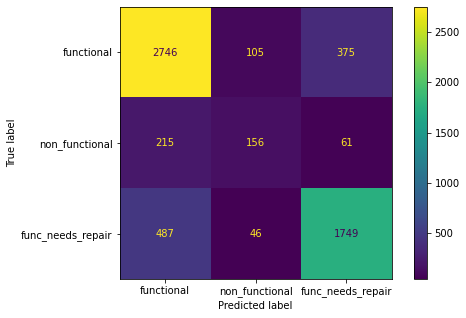

In [ ]:
print(classification_report(y_valid, AdaBoost_pred))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, AdaBoost_pred),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
adaboost_feature_scores = pd.Series(AdaBoost_clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# adaboost_feature_scores

/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:631: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


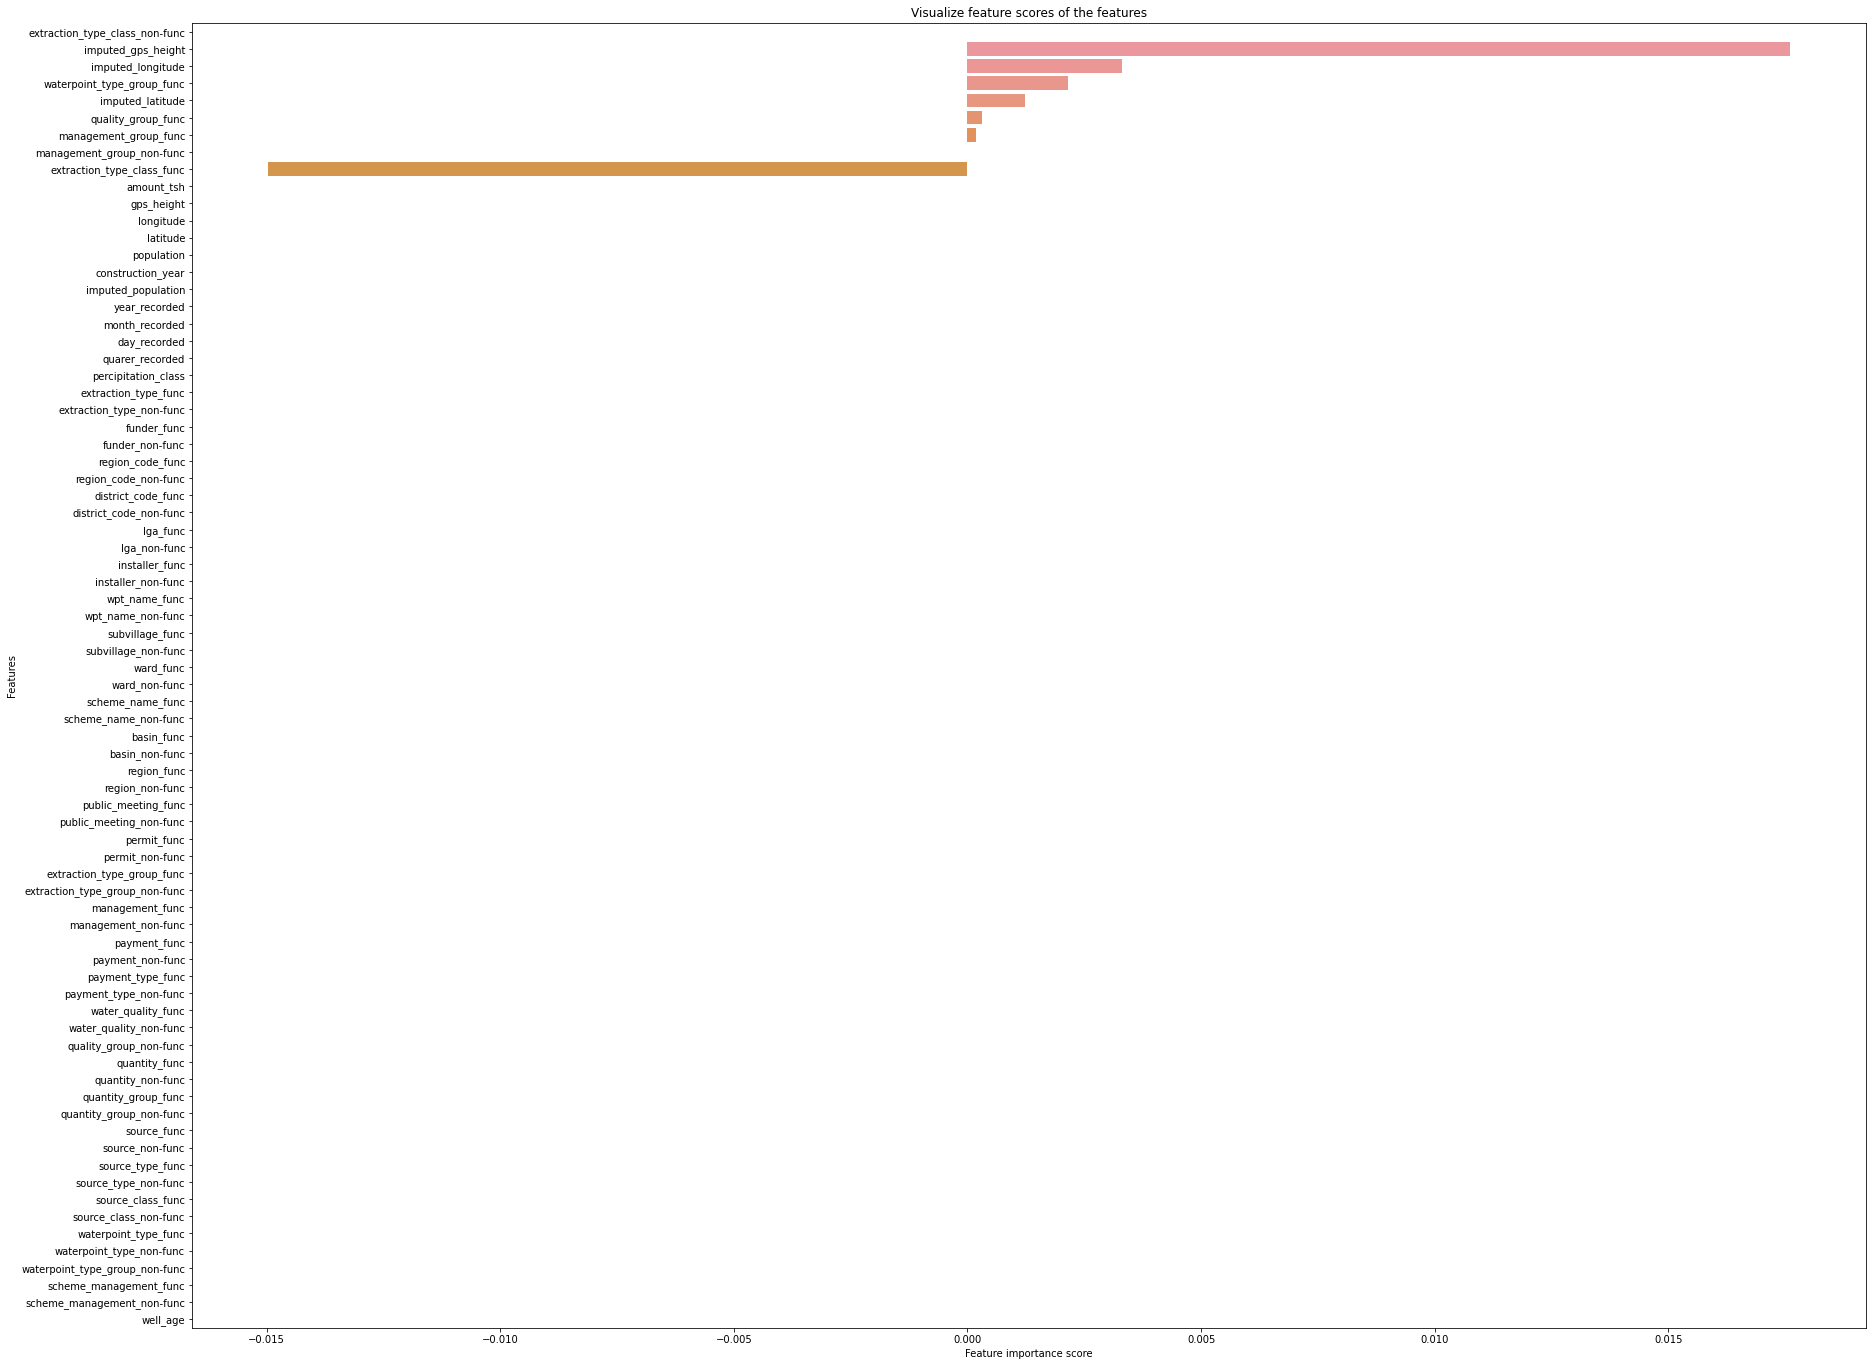

In [ ]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=adaboost_feature_scores, y=adaboost_feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(adaboost_feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

##4.1- Logistic regression

####Fit the Logistic regression model and Tune Hyperparameter

In [ ]:
lr_sgd = SGDClassifier(
    loss = 'log',
    penalty = 'elasticnet',
    n_jobs = -1,
    random_state = 42,
    class_weight = 'balanced'
)

lr_sgd.fit(x_train, y_train)

SGDClassifier(class_weight='balanced', loss='log', n_jobs=-1,
              penalty='elasticnet', random_state=42)

* Hyperparameter Tuning

In [ ]:
params = {
    'alpha' : [0.001, 0.01, 0.1, 1.0, 10]
}
lr_hyperparam = GridSearchCV(lr_sgd, params, scoring='f1', cv=3, n_jobs = -1, verbose = 5, return_train_score = True)
lr_hyperparam.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=SGDClassifier(class_weight='balanced', loss='log',
                                     n_jobs=-1, penalty='elasticnet',
                                     random_state=42),
             n_jobs=-1, param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10]},
             return_train_score=True, scoring='f1', verbose=5)

In [ ]:
lr_hyperparam.best_params_

{'alpha': 0.001}

In [ ]:
lr_full = SGDClassifier(
    alpha = 0.001,
    loss = 'log',
    penalty = 'elasticnet',
    n_jobs = -1,
    random_state = 42,
    class_weight = 'balanced'
)

lr_full.fit(x_train, y_train)

SGDClassifier(alpha=0.001, class_weight='balanced', loss='log', n_jobs=-1,
              penalty='elasticnet', random_state=42)

####Perform Prediction and Display Results for Logistic regression




In [ ]:
lr_preds = lr_full.predict(x_valid)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.00      0.01      3226
           1       0.07      1.00      0.14       432
           2       0.00      0.00      0.00      2282

    accuracy                           0.07      5940
   macro avg       0.36      0.33      0.05      5940
weighted avg       0.55      0.07      0.01      5940



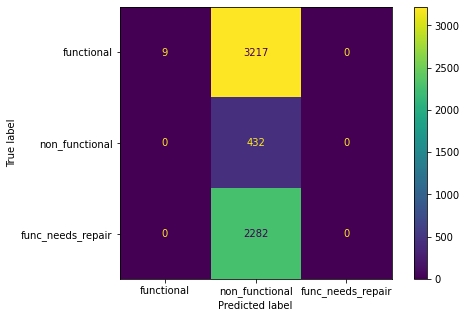

In [ ]:
print(classification_report(y_valid, lr_preds))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, lr_preds),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
lr_table = PrettyTable()
lr_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  # 'Log-loss'
                 ]

lr_table.add_row([
    'Logistic Regression',
    accuracy_score(y_true = y_valid, y_pred = lr_preds),
    f1_score(y_true = y_valid, y_pred = lr_preds, average='weighted'),
    precision_score(y_true = y_valid, y_pred = lr_preds, average='weighted'),
    recall_score(y_true = y_valid, y_pred = lr_preds, average='weighted'),
    # log_loss(y_true = y_valid, y_pred = lr_preds)
])
print(lr_table)

+---------------------+---------------------+----------------------+--------------------+---------------------+
|      Model Name     |       Accuracy      |       F1-Score       |     Precision      |        Recall       |
+---------------------+---------------------+----------------------+--------------------+---------------------+
| Logistic Regression | 0.07424242424242425 | 0.012897145753436019 | 0.5483949254814201 | 0.07424242424242425 |
+---------------------+---------------------+----------------------+--------------------+---------------------+


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####Feature Importances - Logistic Regression

<ipython-input-2925-98f99d594e09>:70: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
<ipython-input-2925-98f99d594e09>:71: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


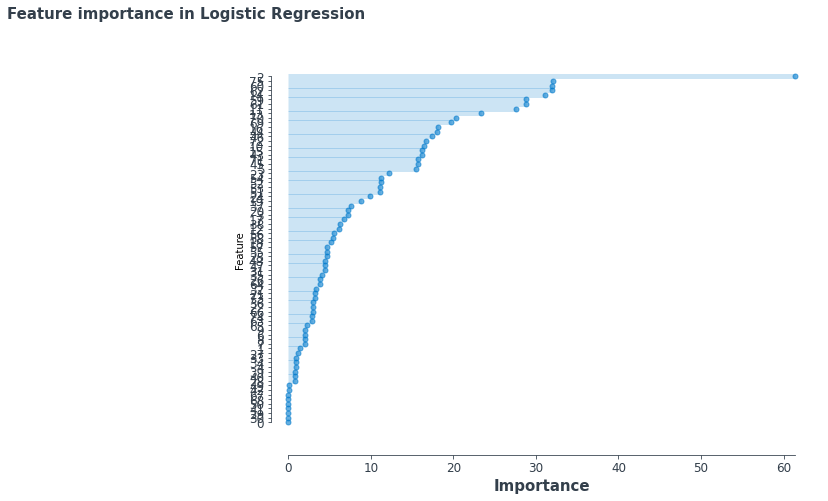

In [ ]:
pretty_importances_plot(
    np.abs(lr_full.coef_[0]), 
    [i for i in range(x_train.shape[1])],
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in Logistic Regression'
)